<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/R00195734_Part_B_Feature_Extract_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [ ]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Sat May  1 19:39:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Some Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics, model_selection
from statistics import mean, median
from time import perf_counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFwe, chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

#### Setup logging

In [ ]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

random.seed(5)
tf.random.set_seed(5)
np.random.seed(5)

#### Mount Google Drive And Copy Files

In [ ]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [ ]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [ ]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [ ]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        gc.collect(0)
        gc.collect(1)
        gc.collect(2)
        gc.collect(0)
        gc.collect(1)
        gc.collect(2)
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-1.0)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_filepath(name):
    return f"{DRIVE_FOLDER}/ckp-{name}"

def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

## 1. Load the VGG Model


In [ ]:
vgg = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

# Use Pretrained Models as Feature Extractors

## Helper functions

Function to run all the specified models as classifiers after extracting features from the supplied model.

In [ ]:
import pandas as pd
import seaborn as sns
gc.collect()

from sklearn.pipeline import Pipeline
import time

def feature_extraction_test(\
                            model_name:str,\
                            model,\
                            trainX,\
                            trainY,\
                            valX,\
                            valY
                            ):
    def secondary_classification(\
                                 model,\
                                 trainX,\
                                 trainY,\
                                 valX,\
                                 valY):
        model.fit(trainX, trainY)
        y_pred = model.predict(valX)
        return accuracy_score(valY, y_pred)

    basic_models = [
        ('DecisionTreeClassifier', lambda: Pipeline([('pca', PCA(n_components=50),), ('dt', DecisionTreeClassifier(random_state=1),)])),
        ('KNeighborsClassifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('knn', KNeighborsClassifier(n_jobs=-1),)])),
        ('NearestCentroid', lambda: Pipeline([('pca', PCA(n_components=100),), ('nearestCentroid', NearestCentroid(),)])),
        ('NaiveBayes', lambda: GaussianNB()),
        ('SVC', lambda: Pipeline([('pca', PCA(n_components=200),), ('svc', SVC(random_state=1),)])),
        ('Random Forest', lambda: RandomForestClassifier(random_state=1, n_jobs=-1)),
        #('Gradient Boost', lambda: Pipeline([('pca', PCA(n_components=25),), ('gb',GradientBoostingClassifier(),)])),
        ('LDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('lda', LinearDiscriminantAnalysis(),)])),
        ('QDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('qda',QuadraticDiscriminantAnalysis(),)])),
        ('Logistic Regression', lambda: LogisticRegression(random_state=1, n_jobs=-1)),
        ('Ridge', lambda: Pipeline([('pca', PCA(n_components=50),), ('rc',RidgeClassifier(random_state=1),)])),
        ('Bagging', lambda: Pipeline([('pca', PCA(n_components=100),), ('bg', BaggingClassifier(random_state=1, n_jobs=-1),)])),
        #('SGD Classifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('sgd', SGDClassifier(random_state=1),)])),
        ('SGD Classifier', lambda: SGDClassifier(random_state=1, n_jobs=-1, max_iter=2000)),
        ('Passive Aggressive', lambda: Pipeline([('pca', PCA(n_components=50),),('pac', PassiveAggressiveClassifier(random_state=1, n_jobs=-1),)])),
    ]

    m_names = []
    m_acc = []
    t_trainX = model.predict(trainX)
    t_valX = model.predict(valX)
    t_trainX = t_trainX.reshape(t_trainX.shape[0], -1)
    t_valX = t_valX.reshape(t_valX.shape[0], -1)
    scaler = StandardScaler().fit(t_trainX)
    t_trainX = scaler.transform(t_trainX)
    t_valX = scaler.transform(t_valX)

    for (n, m) in basic_models:
        gc.collect()
        print(f"Training model {n}")
        t1 = time.perf_counter()
        accuracy = secondary_classification(m(),\
                                            t_trainX,\
                                            trainY,\
                                            t_valX,\
                                            valY)
        t2 = time.perf_counter()
        print(f"Accuracy = {accuracy:0.3f}, \t\t\t\tTime taken = {(t2 - t1):2.2f}s")
        m_names.append(n)
        m_acc.append(accuracy)
        
    df = pd.DataFrame({"Model": pd.Series(m_names), "accuracy": pd.Series(m_acc)})
    p = sns.barplot(y='Model', x='accuracy', data=df, orient='h')
    p.set_title(model_name)
    plt.show()
    return m_names, m_acc

def print_model(model):
    plot = tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
    IPython.display.display(plot)
    #print(model.summary())   


## Run all tests with VGG16

Training model DecisionTreeClassifier
Accuracy = 0.643, 				Time taken = 4.73s
Training model KNeighborsClassifier
Accuracy = 0.777, 				Time taken = 11.04s
Training model NearestCentroid
Accuracy = 0.653, 				Time taken = 3.71s
Training model NaiveBayes
Accuracy = 0.502, 				Time taken = 0.81s
Training model SVC
Accuracy = 0.840, 				Time taken = 64.86s
Training model Random Forest
Accuracy = 0.818, 				Time taken = 13.53s
Training model LDA
Accuracy = 0.700, 				Time taken = 2.40s
Training model QDA
Accuracy = 0.677, 				Time taken = 2.13s
Training model Logistic Regression
Accuracy = 0.850, 				Time taken = 29.08s
Training model Ridge
Accuracy = 0.732, 				Time taken = 2.76s
Training model Bagging
Accuracy = 0.755, 				Time taken = 12.82s
Training model SGD Classifier
Accuracy = 0.856, 				Time taken = 107.81s
Training model Passive Aggressive
Accuracy = 0.751, 				Time taken = 2.88s


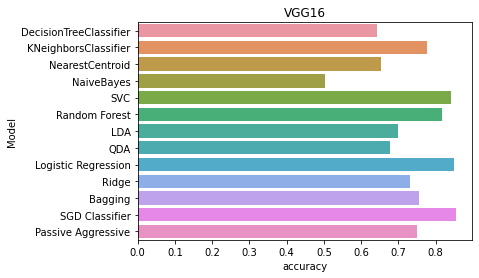

In [ ]:
vgg16 = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vg16_names, vgg16_acc = feature_extraction_test("VGG16", vgg16, trainX, trainY, valX, valY)


## Run all tests with VGG19

80142336/80134624 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.611, 				Time taken = 4.79s
Training model KNeighborsClassifier
Accuracy = 0.741, 				Time taken = 10.63s
Training model NearestCentroid
Accuracy = 0.617, 				Time taken = 3.23s
Training model NaiveBayes
Accuracy = 0.470, 				Time taken = 0.79s
Training model SVC
Accuracy = 0.804, 				Time taken = 71.95s
Training model Random Forest
Accuracy = 0.777, 				Time taken = 14.33s
Training model LDA
Accuracy = 0.659, 				Time taken = 2.09s
Training model QDA
Accuracy = 0.633, 				Time taken = 2.44s
Training model Logistic Regression
Accuracy = 0.815, 				Time taken = 28.43s
Training model Ridge
Accuracy = 0.689, 				Time taken = 3.23s
Training model Bagging
Accuracy = 0.720, 				Time taken = 12.93s
Training model SGD Classifier
Accuracy = 0.816, 				Time taken = 131.07s
Training model Passive Aggressive
Accuracy = 0.689, 				Time taken = 3.07s


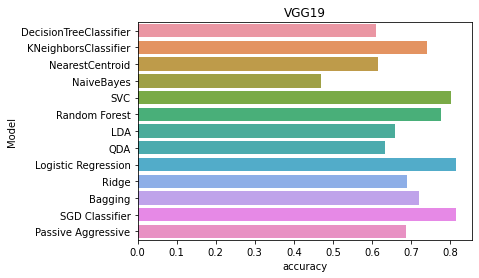

In [ ]:
gc.collect()
vgg19 = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_names, vgg19_acc = feature_extraction_test("VGG19",\
                                                 vgg19,\
                                                 trainX,\
                                                 trainY,\
                                                 valX,\
                                                 valY)

## Run all tests with ResNet50

94674944/94668760 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.555, 				Time taken = 9.45s
Training model KNeighborsClassifier
Accuracy = 0.700, 				Time taken = 18.19s
Training model NearestCentroid
Accuracy = 0.639, 				Time taken = 8.65s
Training model NaiveBayes
Accuracy = 0.510, 				Time taken = 2.67s
Training model SVC
Accuracy = 0.801, 				Time taken = 86.58s
Training model Random Forest
Accuracy = 0.757, 				Time taken = 16.96s
Training model LDA
Accuracy = 0.625, 				Time taken = 6.60s
Training model QDA
Accuracy = 0.554, 				Time taken = 6.41s
Training model Logistic Regression
Accuracy = 0.815, 				Time taken = 114.49s
Training model Ridge
Accuracy = 0.704, 				Time taken = 8.20s
Training model Bagging
Accuracy = 0.667, 				Time taken = 18.42s
Training model SGD Classifier
Accuracy = 0.820, 				Time taken = 238.65s
Training model Passive Aggressive
Accuracy = 0.677, 				Time taken = 7.80s


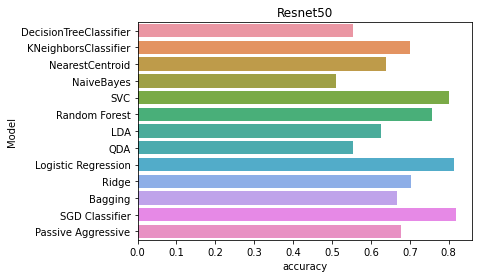

In [ ]:
gc.collect()
resnet50 = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)
                               
resnet50_names, resnet50_acc = feature_extraction_test(\
                                                       "Resnet50",\
                                                       resnet50,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

## Run all tests with DenseNet

74842112/74836368 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.692, 				Time taken = 9.04s
Training model KNeighborsClassifier
Accuracy = 0.854, 				Time taken = 15.76s
Training model NearestCentroid
Accuracy = 0.734, 				Time taken = 8.37s
Training model NaiveBayes
Accuracy = 0.710, 				Time taken = 2.77s
Training model SVC
Accuracy = 0.922, 				Time taken = 59.43s
Training model Random Forest
Accuracy = 0.838, 				Time taken = 51.04s
Training model LDA
Accuracy = 0.792, 				Time taken = 5.46s
Training model QDA
Accuracy = 0.798, 				Time taken = 5.55s
Training model Logistic Regression
Accuracy = 0.927, 				Time taken = 107.92s
Training model Ridge
Accuracy = 0.855, 				Time taken = 7.09s
Training model Bagging
Accuracy = 0.780, 				Time taken = 18.64s
Training model SGD Classifier
Accuracy = 0.917, 				Time taken = 46.77s
Training model Passive Aggressive
Accuracy = 0.819, 				Time taken = 7.19s


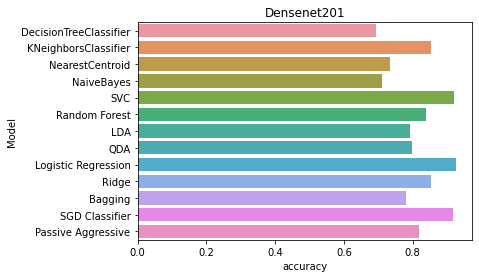

In [ ]:
gc.collect()
densenet = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)
densenet_names, densenet_acc = feature_extraction_test(\
                                                       "Densenet201",\
                                                       densenet,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

## Comapre all models as feature extractors

In [ ]:
def compare_pretrained_models(plotsize=None):
    def pretty_print(x):
        dfs = pd.DataFrame(x)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        print(dfs)
    classifier_names = densenet_names
    models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    data = {}
    data["Pretrained Model"] = pretrained
    for i, name in enumerate(classifier_names):
        arr = []
        for acc_arr in accuracies:
            arr.append(acc_arr[i])
        data[name] = arr
    pretty_print(data)

    parameters = [m.count_params() / (100_000_000) for m in models]
    data["Trainable Params (100s of millions)"] = parameters
    dfs = pd.DataFrame(data)
    dfs1 = pd.melt(dfs, id_vars="Pretrained Model")
    print(dfs1)
    if None == plotsize:
        sns.set(rc={'figure.figsize':(20, 15,)})
    else:
        sns.set(rc={'figure.figsize':plotsize})
    p = sns.factorplot(hue="Pretrained Model", x='value', y='variable', data=dfs1, kind='bar', size=10, orient='h')
    plt.title('Comparison of various pre-trained models')
    plt.show()

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.554792              0.700208   
3         DenseNet                0.692083              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.818125  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.776667  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.757292  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.838333  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  Passive Aggressive  
0             0.850000  0.732083  0.755208        0.855833            0.750625  
1             0.815208  0.688750  0.720000        0.816458            0.688542  
2             0.8145

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


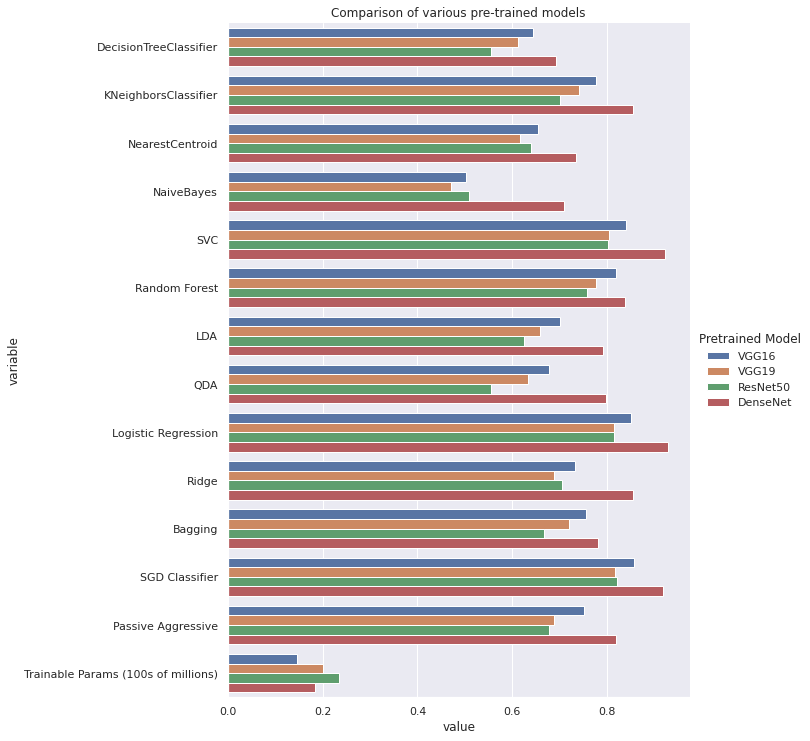

In [ ]:
gc.collect()
compare_pretrained_models()

In [ ]:
def print_all_saved_accuracies():
    classifier_names = densenet_names
    #models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    
    print()
    for n, a in zip(pretrained, accuracies):
        print(n, ":", len(a), a)
    print("Classifier names", ":", len(classifier_names), classifier_names)
    #print("Trainable Params", ":", [m.count_params() / 100_000_000 for m in models])
    print("Trainable Params", ":", [0.14714688, 0.20024384, 0.235648, 0.18321984])
print_all_saved_accuracies()


VGG16 : 13 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625]
VGG19 : 13 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667]
ResNet50 : 13 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334]
DenseNet : 13 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'NaiveBayes', 'SVC', 'Random Forest', 'LDA', 'QDA', 'Logistic

# Fine Tune

## Helper Functions

Take two models and perform a two phased fine-tuning training regime.

The first model is the pre-trained model without the final layer.

The second model is a small hand-crafted model that is appended to the layer.

In [ ]:
def combine_and_train_finetune(\
                               model1,\
                               model2,\
                               trainX,\
                               trainY,\
                               valX,\
                               valY,\
                               nepochs,
                               layer_to_unfreeze):
    # Since we will be training multiple pre-trained models, the parameter
    # layer_to_unfreeze will give us flexitiliby in the second phase of
    # fine tuning   
    combined = tf.keras.Sequential(name=f"{model1.name}-finetuned")
    model1.trainable = False
    combined.add(model1)
    combined.add(model2)

    logging.info("Phase 1 starting...")
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    combined.compile(optimizer=opt,\
                     loss='sparse_categorical_crossentropy',\
                     metrics=['accuracy'])
    plot = Plot()
    history = combined.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=nepochs,\
                    callbacks=get_callbacks_decay_after(-1, combined.name))
    plot.plot_history(history, nepochs, "combined - Phase 1")
    plt.show()
    logging.info("OK.")

    # Load the best checkpoint before fine tuning
    logging.info("Loading weights from checkpoint...")
    combined.load_weights(get_checkpoint_filepath(combined.name))
    logging.info("OK.")

    logging.info("Phase 2 starting...")
    model1.trainable = True
    trainableFlag = False
    # Unfreeze some layers of the pre-trained network
    for layer in model1.layers:
        if layer.name == layer_to_unfreeze:
            trainableFlag = True
        layer.trainable = trainableFlag
    opt = tf.keras.optimizers.RMSprop(learning_rate=1.0e-5)
    combined.compile(optimizer=opt,\
                     loss='sparse_categorical_crossentropy',\
                     metrics=['accuracy'])
    history = combined.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=nepochs,
                    callbacks=get_callbacks_decay_after(2, combined.name))
    logging.info("OK.")

    plot.plot_history(history, nepochs, "combined - Phase 2")
    plt.show()
    plot.superplot()
    plt.show()

    return combined, history

   

## Build a network with two dense layers with dropout

In [ ]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class ShallowNet:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        return model

# Test the above network with all pre-trained models

## VGG16

2021-05-01 20:05:04,335 - root - INFO - Phase 1 starting...
2021-05-01 20:05:04,335 - root - INFO - Phase 1 starting...
Epoch 1/25
600/600 [==============================] - 6s 8ms/step - loss: 0.9940 - accuracy: 0.6558 - val_loss: 0.6280 - val_accuracy: 0.7921
Epoch 2/25
600/600 [==============================] - 5s 8ms/step - loss: 0.6129 - accuracy: 0.7900 - val_loss: 0.4959 - val_accuracy: 0.8342
Epoch 3/25
600/600 [==============================] - 5s 8ms/step - loss: 0.5438 - accuracy: 0.8099 - val_loss: 0.4891 - val_accuracy: 0.8333
Epoch 4/25
600/600 [==============================] - 5s 8ms/step - loss: 0.5110 - accuracy: 0.8284 - val_loss: 0.4902 - val_accuracy: 0.8442
Epoch 5/25
600/600 [==============================] - 5s 7ms/step - loss: 0.5098 - accuracy: 0.8328 - val_loss: 0.4790 - val_accuracy: 0.8402
Epoch 6/25
600/600 [==============================] - 5s 8ms/step - loss: 0.4861 - accuracy: 0.8370 - val_loss: 0.4621 - val_accuracy: 0.8573
Epoch 7/25
600/600 [========

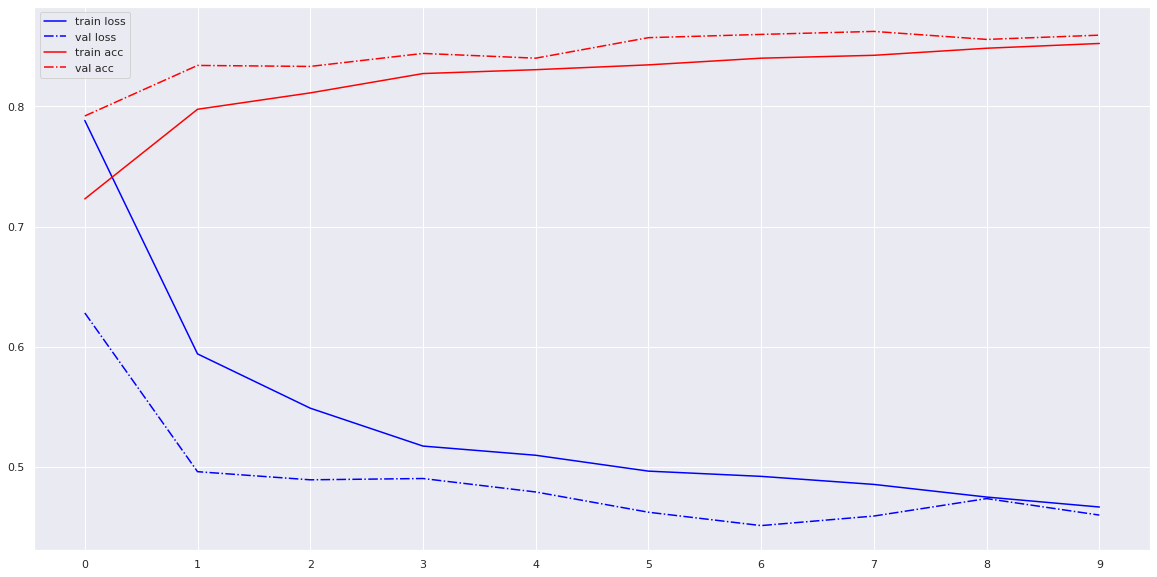

Best validation accuracy: 0.862500011920929, epoch = 7
Best validation loss: 0.450961709022522, epoch = 6
2021-05-01 20:05:58,405 - root - INFO - OK.
2021-05-01 20:05:58,405 - root - INFO - OK.
2021-05-01 20:05:58,411 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:05:58,411 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:05:58,563 - root - INFO - OK.
2021-05-01 20:05:58,563 - root - INFO - OK.
2021-05-01 20:05:58,566 - root - INFO - Phase 2 starting...
2021-05-01 20:05:58,566 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 9s 13ms/step - loss: 0.4311 - accuracy: 0.8650 - val_loss: 0.4045 - val_accuracy: 0.8817
Epoch 2/25
600/600 [==============================] - 8s 12ms/step - loss: 0.2777 - accuracy: 0.9061 - val_loss: 0.3080 - val_accuracy: 0.9104
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 8s 12ms/step - loss: 0.1700 - accuracy: 0.94

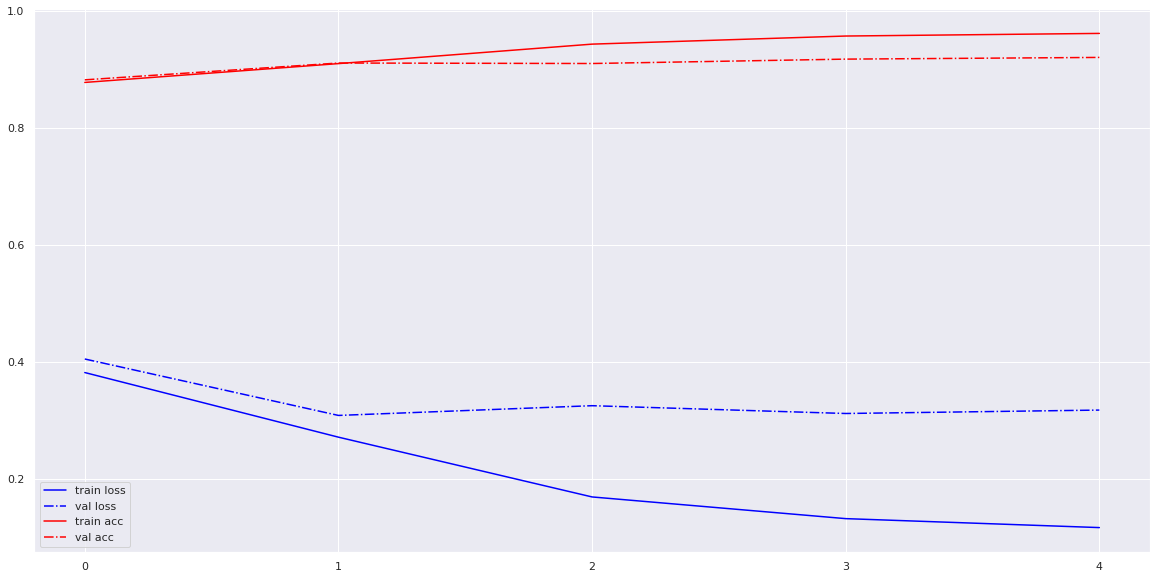

Best validation accuracy: 0.9200000166893005, epoch = 4
Best validation loss: 0.3079824447631836, epoch = 1


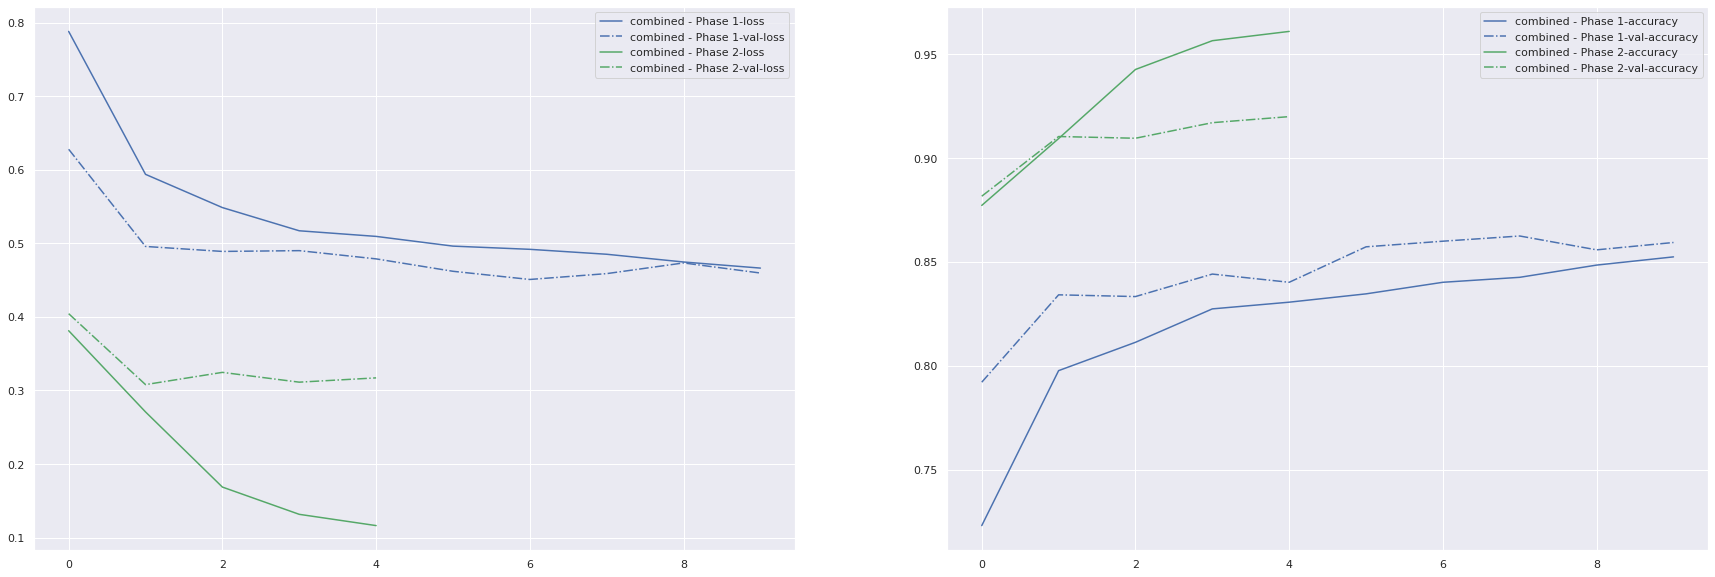

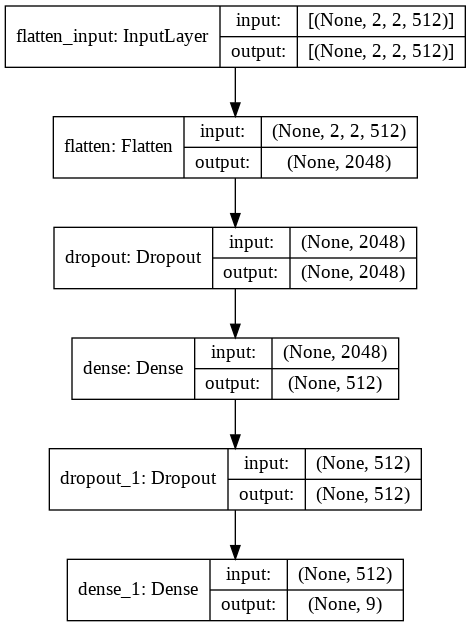

Model: "BaseLineShallowNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 1,053,705
Trainable params: 1,053,705
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
vgg16_ft = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16_ft.trainable = False

myModel = ShallowNet.build(vgg16_ft.output_shape, n_classes)

vgg16_combined_model, vgg16_combined_history = combine_and_train_finetune(vgg16_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')
vgg16_acc.append(max(vgg16_combined_history.history['val_accuracy']))
print_model(myModel)


In [ ]:
def print_all_saved_accuracies():
    classifier_names = densenet_names
    models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    
    print()
    for n, a in zip(pretrained, accuracies):
        print(n, ":", len(a), a)
    print("Classifier names", ":", len(classifier_names), classifier_names)
    print("Trainable Params", ":", [m.count_params() / 100_000_000 for m in models])
print_all_saved_accuracies()


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005]
VGG19 : 13 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667]
ResNet50 : 13 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334]
DenseNet : 13 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'NaiveBayes', 'SVC', 'Random Forest', 'LD

## VGG 19

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

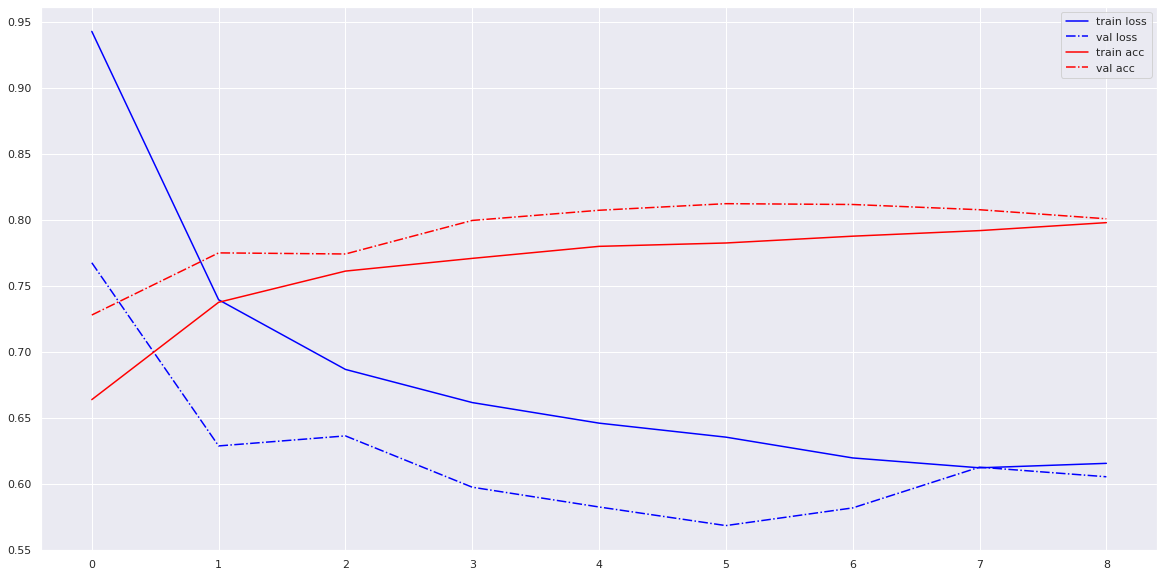

Best validation accuracy: 0.81229168176651, epoch = 5
Best validation loss: 0.5683433413505554, epoch = 5
2021-05-01 20:07:39,368 - root - INFO - OK.
2021-05-01 20:07:39,368 - root - INFO - OK.
2021-05-01 20:07:39,370 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:07:39,370 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:07:39,558 - root - INFO - OK.
2021-05-01 20:07:39,558 - root - INFO - OK.
2021-05-01 20:07:39,560 - root - INFO - Phase 2 starting...
2021-05-01 20:07:39,560 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 9s 13ms/step - loss: 0.5154 - accuracy: 0.8246 - val_loss: 0.4940 - val_accuracy: 0.8425
Epoch 2/25
600/600 [==============================] - 8s 12ms/step - loss: 0.3747 - accuracy: 0.8729 - val_loss: 0.4260 - val_accuracy: 0.8535
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 8s 12ms/step - loss: 0.2754 - accuracy: 0.90

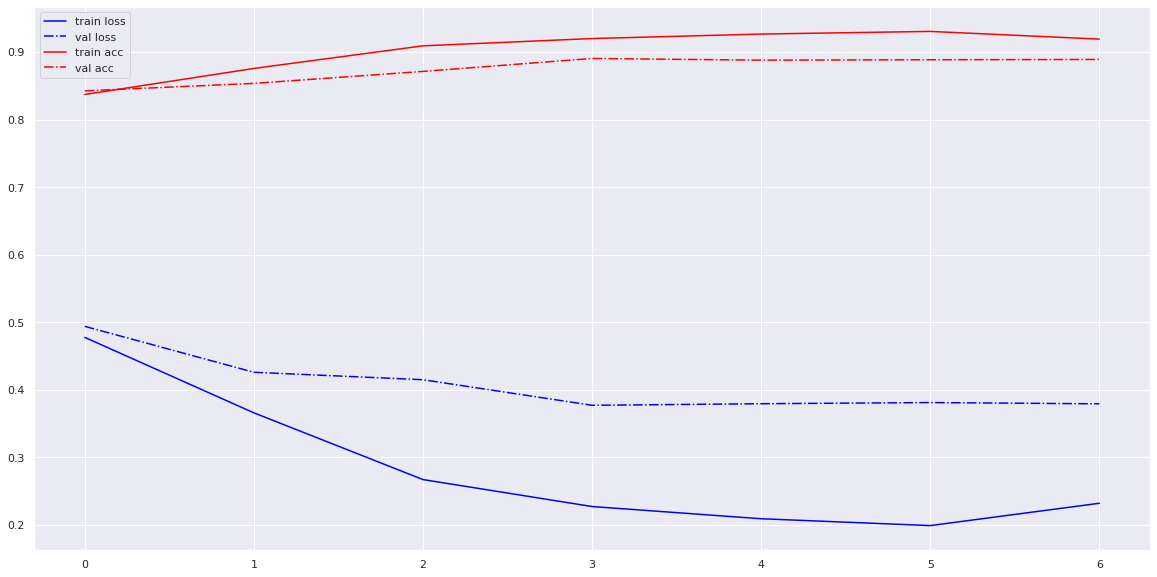

Best validation accuracy: 0.89041668176651, epoch = 3
Best validation loss: 0.3771427273750305, epoch = 3


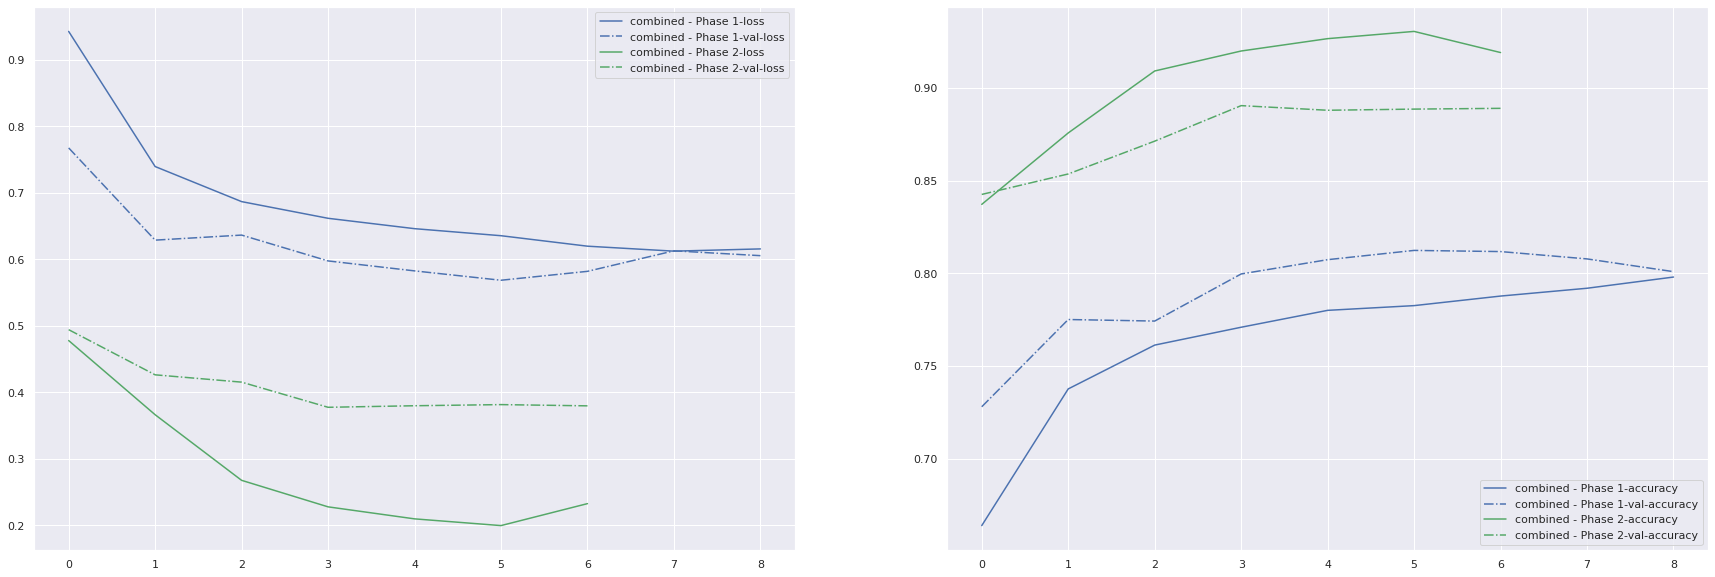


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005]
VGG19 : 14 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651]
ResNet50 : 13 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334]
DenseNet : 13 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'NaiveBayes', 'SVC', 'R

In [ ]:
gc.collect(0)
gc.collect(1)
gc.collect(2)
vgg19_ft = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_ft.trainable = False
print(vgg19_ft.summary())

myModel = ShallowNet.build(vgg19_ft.output_shape, n_classes)

vgg19_combined_model, vgg19_combined_history = combine_and_train_finetune(vgg19_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_pool')
vgg19_acc.append(max(vgg19_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## DenseNet

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

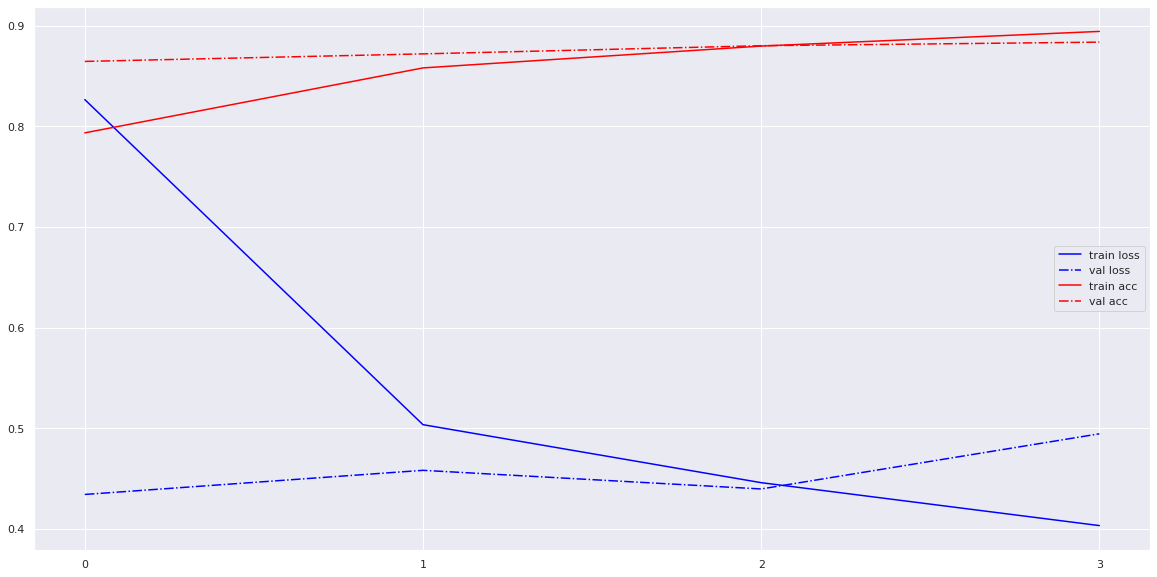

Best validation accuracy: 0.8837500214576721, epoch = 3
Best validation loss: 0.43399983644485474, epoch = 0
2021-05-01 20:10:15,731 - root - INFO - OK.
2021-05-01 20:10:15,731 - root - INFO - OK.
2021-05-01 20:10:15,734 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:10:15,734 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:10:22,108 - root - INFO - OK.
2021-05-01 20:10:22,108 - root - INFO - OK.
2021-05-01 20:10:22,112 - root - INFO - Phase 2 starting...
2021-05-01 20:10:22,112 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 32s 35ms/step - loss: 1.4480 - accuracy: 0.8519 - val_loss: 0.9160 - val_accuracy: 0.8910
Epoch 2/26
600/600 [==============================] - 19s 30ms/step - loss: 0.6003 - accuracy: 0.9098 - val_loss: 0.7879 - val_accuracy: 0.8994
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 19s 30ms/step - loss: 0.5095 - accuracy

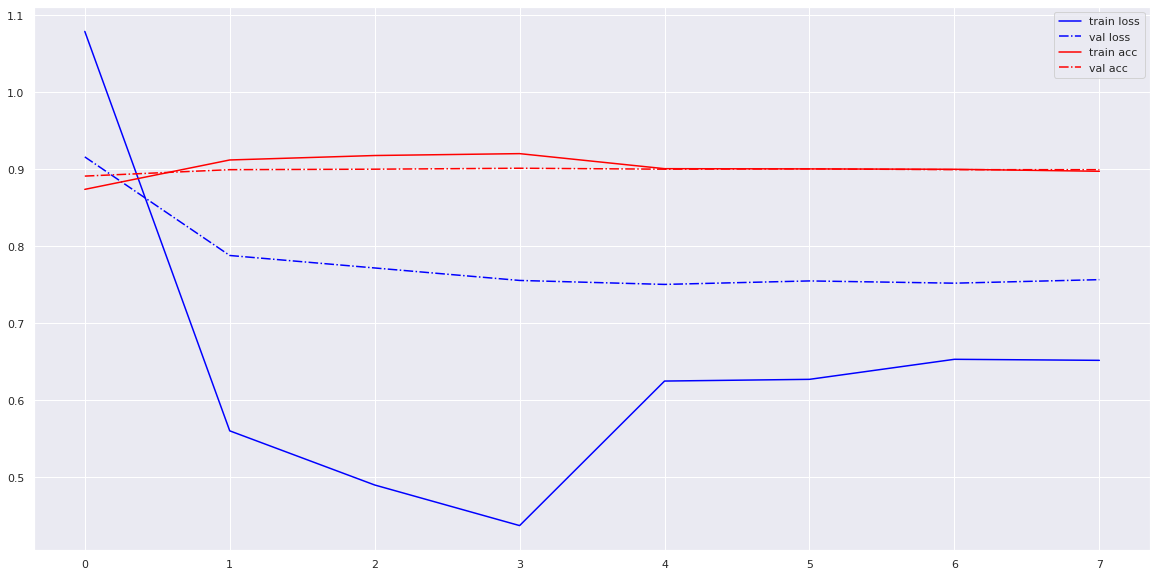

Best validation accuracy: 0.9012500047683716, epoch = 3
Best validation loss: 0.7503511309623718, epoch = 4


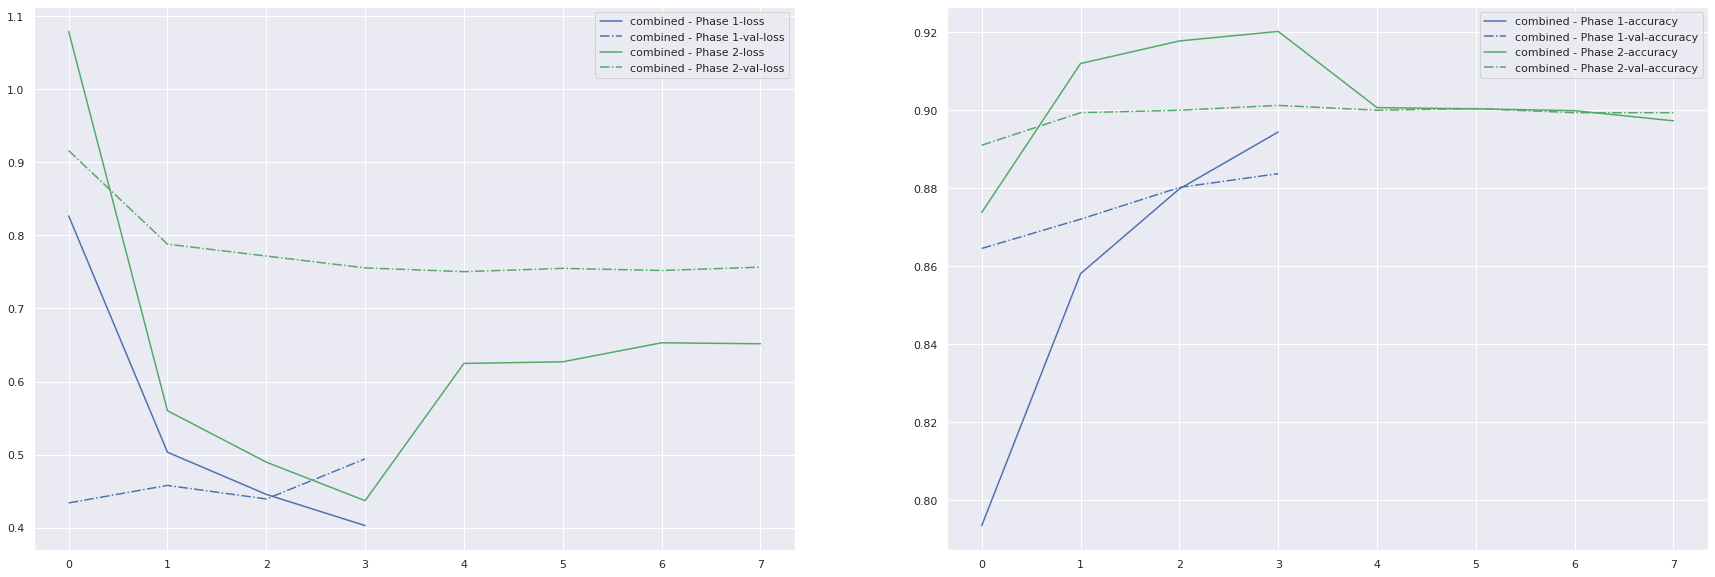


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005]
VGG19 : 14 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651]
ResNet50 : 13 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334]
DenseNet : 14 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875, 0.9012500047683716]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'NearestCentroid', 'Na

In [ ]:
del vgg19_ft
gc.collect(0)
gc.collect(1)
gc.collect(2)
gc.collect(0)
gc.collect(1)
gc.collect(2)
densenet_ft = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)

densenet_ft.trainable = False
print(densenet_ft.summary())

myModel = ShallowNet.build(densenet_ft.output_shape, n_classes)

densenet_combined_model, densenet_combined_history = combine_and_train_finetune(densenet_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block31_2_conv')
densenet_acc.append(max(densenet_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## ResNet50

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

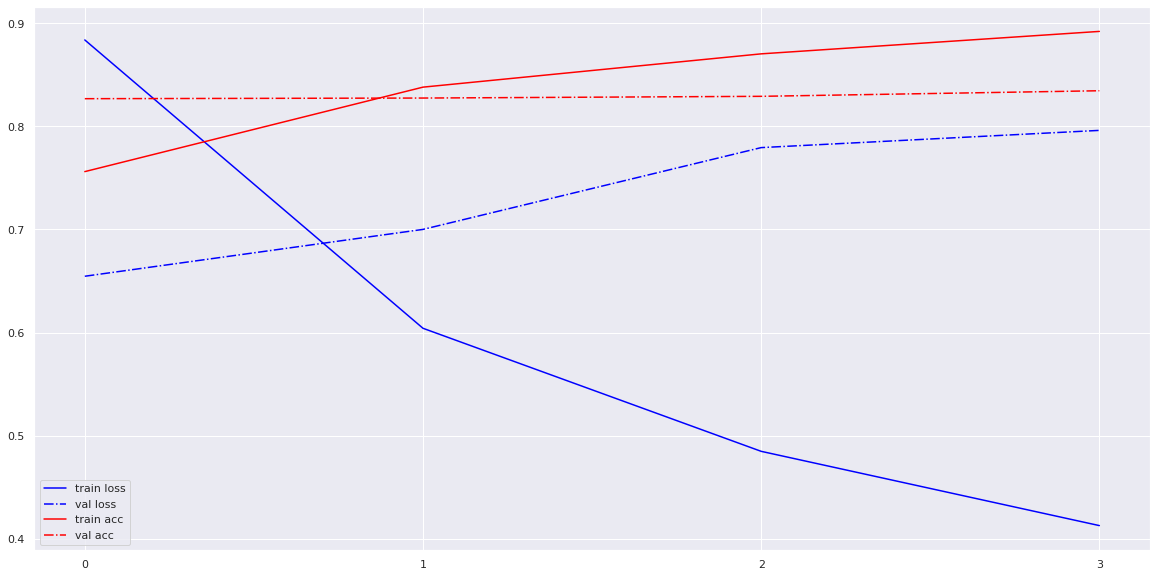

Best validation accuracy: 0.8345833420753479, epoch = 3
Best validation loss: 0.6546540260314941, epoch = 0
2021-05-01 20:13:50,911 - root - INFO - OK.
2021-05-01 20:13:50,911 - root - INFO - OK.
2021-05-01 20:13:50,916 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:13:50,916 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:13:51,638 - root - INFO - OK.
2021-05-01 20:13:51,638 - root - INFO - OK.
2021-05-01 20:13:51,641 - root - INFO - Phase 2 starting...
2021-05-01 20:13:51,641 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 13s 15ms/step - loss: 3.0727 - accuracy: 0.8093 - val_loss: 2.9486 - val_accuracy: 0.8129
Epoch 2/26
600/600 [==============================] - 9s 14ms/step - loss: 1.3681 - accuracy: 0.8432 - val_loss: 1.8028 - val_accuracy: 0.8242
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 9s 14ms/step - loss: 0.8193 - accuracy: 0

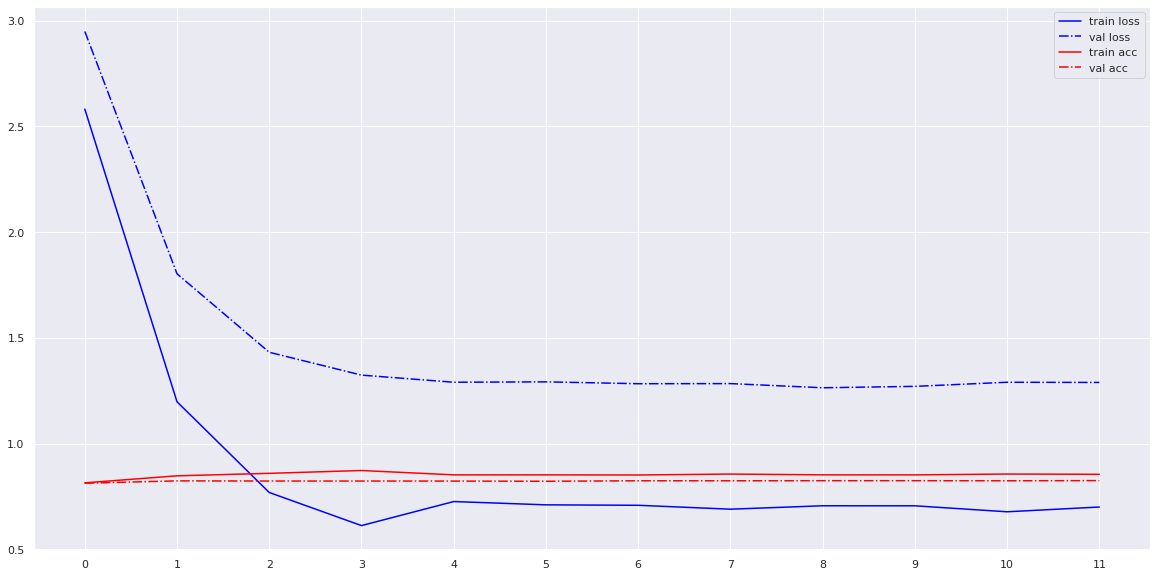

Best validation accuracy: 0.8254166841506958, epoch = 11
Best validation loss: 1.2642154693603516, epoch = 8


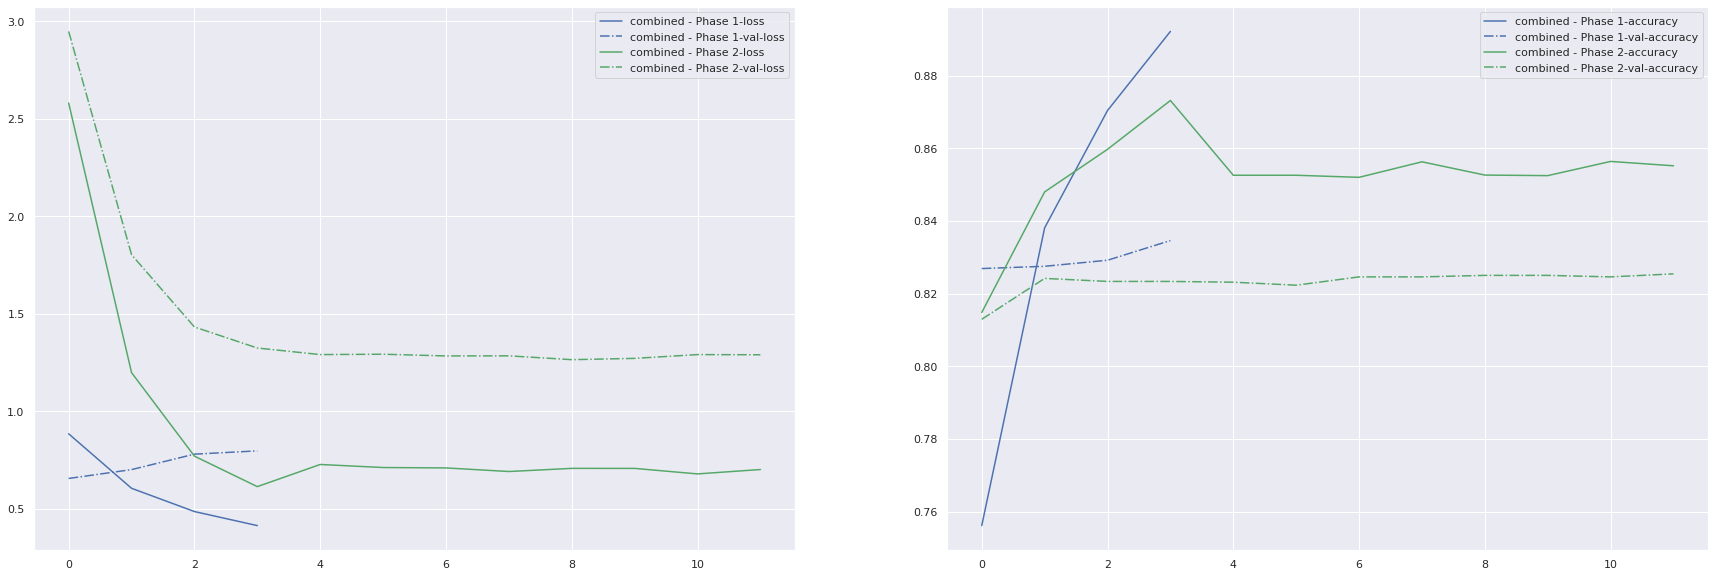


VGG16 : 14 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005]
VGG19 : 14 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651]
ResNet50 : 14 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958]
DenseNet : 14 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875, 0.9012500047683716]
Classifier names : 13 ['DecisionTreeClassifier', 'KNeighborsClassifier', 'N

In [ ]:
gc.collect()
gc.collect()

resnet50_ft = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)

resnet50_ft.trainable = False
print(resnet50_ft.summary())

myModel = ShallowNet.build(resnet50_ft.output_shape, n_classes)

resnet50_combined_model, resnet50_combined_history = combine_and_train_finetune(resnet50_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block3_1_conv')
resnet50_acc.append(max(resnet50_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## Compare all runs

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.554792              0.700208   
3         DenseNet                0.692083              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.818125  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.776667  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.757292  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.838333  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  \
0             0.850000  0.732083  0.755208        0.855833   
1             0.815208  0.688750  0.720000        0.816458   
2             0.814583  0.704167  0.666875        0.819792   
3             0

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


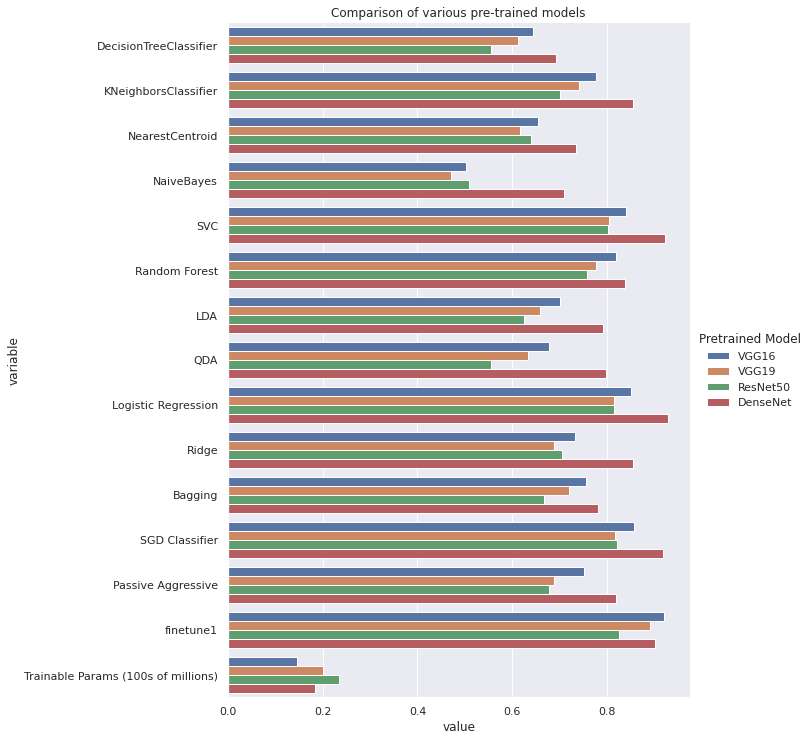

In [ ]:
densenet_names.append('finetune1')
compare_pretrained_models()

# Build a model with three dense layers

Build a more complex model than the last model we saw and test it with all networks

In [ ]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class ThreeAdditionalLayers:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(512, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        #print_model(model)
        return model

## VGG16

2021-05-01 20:17:14,489 - root - INFO - Phase 1 starting...
2021-05-01 20:17:14,489 - root - INFO - Phase 1 starting...
Epoch 1/25
600/600 [==============================] - 7s 8ms/step - loss: 1.1519 - accuracy: 0.6118 - val_loss: 0.6798 - val_accuracy: 0.7650
Epoch 2/25
600/600 [==============================] - 6s 8ms/step - loss: 0.6773 - accuracy: 0.7741 - val_loss: 0.5203 - val_accuracy: 0.8323
Epoch 3/25
600/600 [==============================] - 6s 8ms/step - loss: 0.6291 - accuracy: 0.7948 - val_loss: 0.5865 - val_accuracy: 0.8098
Epoch 4/25
600/600 [==============================] - 6s 8ms/step - loss: 0.6082 - accuracy: 0.8033 - val_loss: 0.5624 - val_accuracy: 0.8271
Epoch 5/25
600/600 [==============================] - 6s 8ms/step - loss: 0.6147 - accuracy: 0.8110 - val_loss: 0.6105 - val_accuracy: 0.8160
Epoch 00005: early stopping


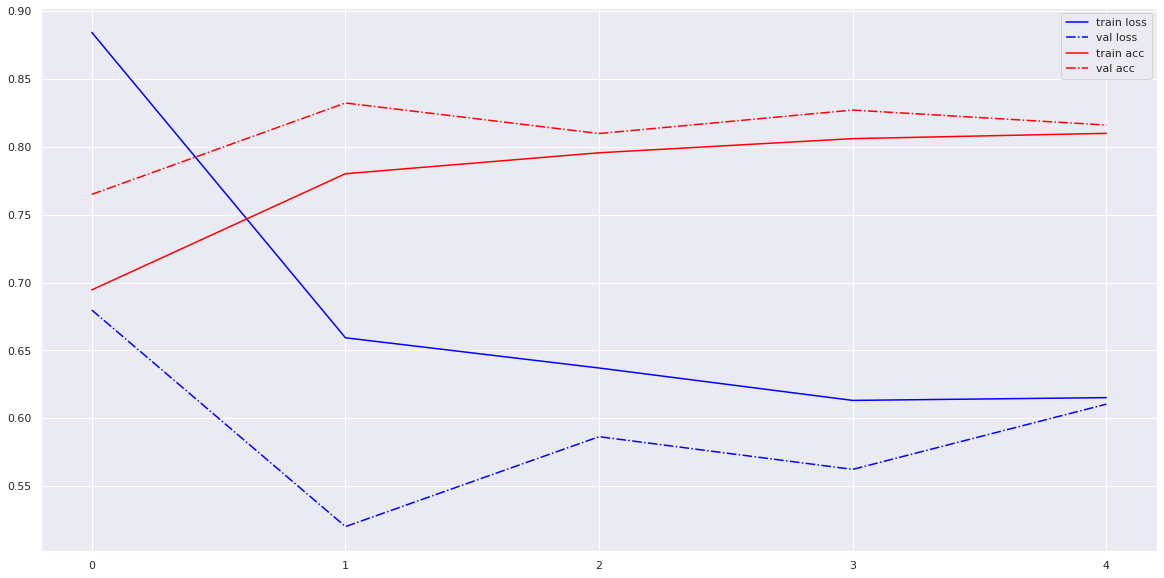

Best validation accuracy: 0.8322916626930237, epoch = 1
Best validation loss: 0.520289421081543, epoch = 1
2021-05-01 20:17:46,607 - root - INFO - OK.
2021-05-01 20:17:46,607 - root - INFO - OK.
2021-05-01 20:17:46,611 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:17:46,611 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:17:46,785 - root - INFO - OK.
2021-05-01 20:17:46,785 - root - INFO - OK.
2021-05-01 20:17:46,788 - root - INFO - Phase 2 starting...
2021-05-01 20:17:46,788 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 10s 14ms/step - loss: 0.4532 - accuracy: 0.8497 - val_loss: 0.3885 - val_accuracy: 0.8729
Epoch 2/25
600/600 [==============================] - 9s 13ms/step - loss: 0.2708 - accuracy: 0.9104 - val_loss: 0.3166 - val_accuracy: 0.9027
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 9s 13ms/step - loss: 0.2259 - accuracy: 0.

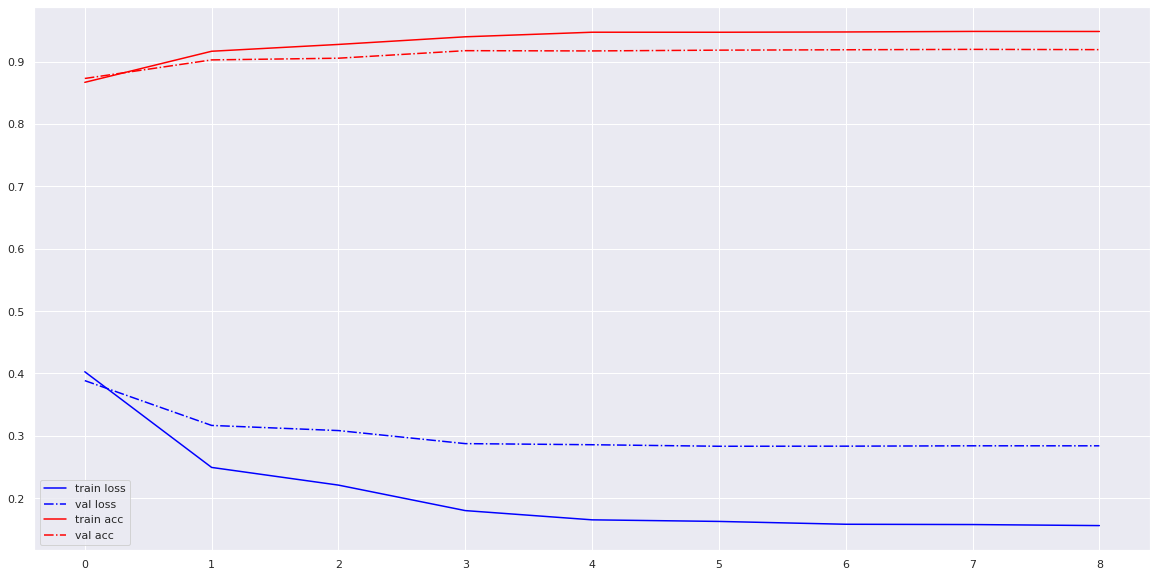

Best validation accuracy: 0.9195833206176758, epoch = 7
Best validation loss: 0.2832140624523163, epoch = 5


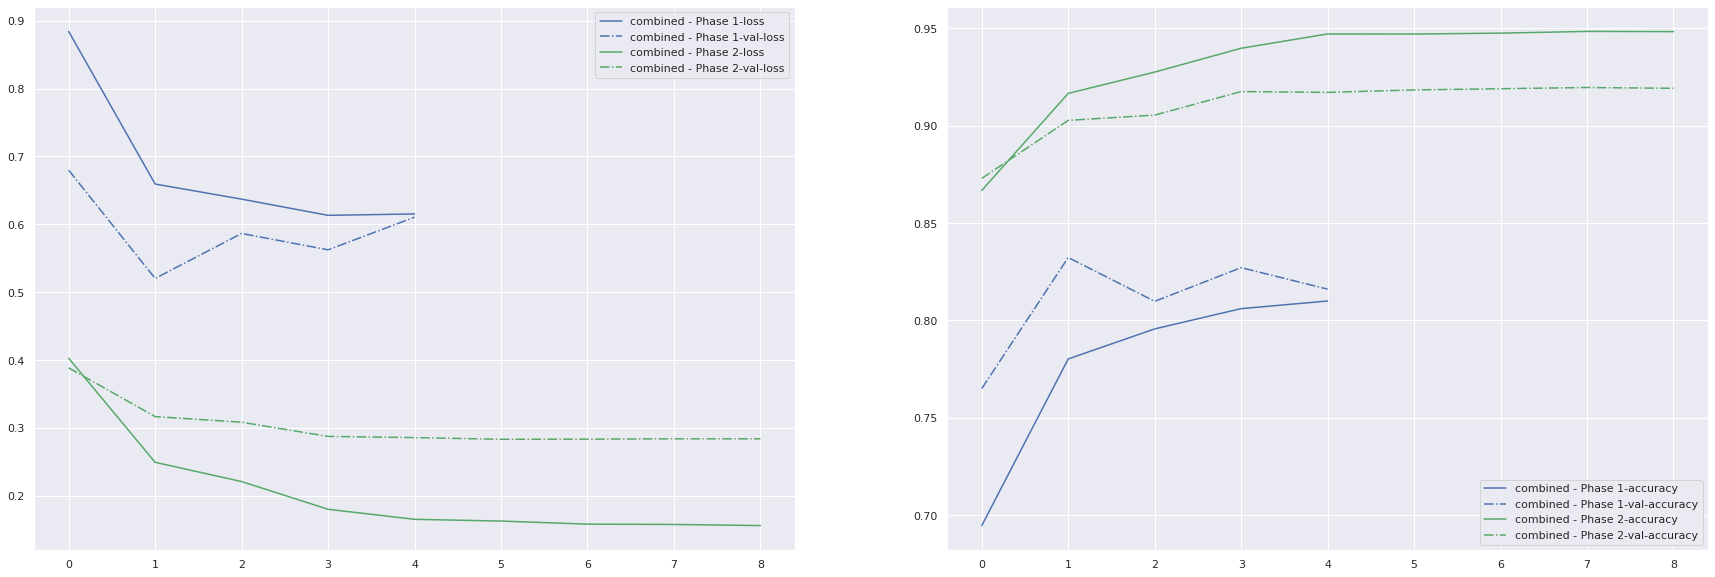

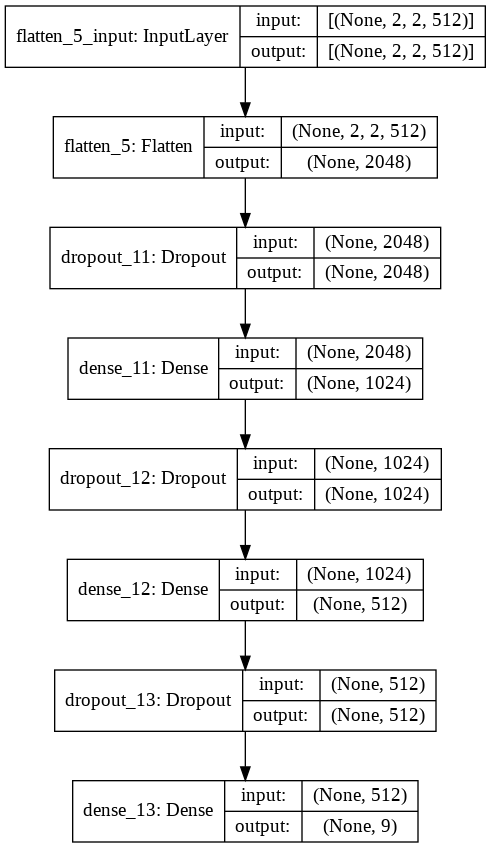

Model: "BaseLineShallowNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 9)          

In [ ]:
vgg16_ft = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16_ft.trainable = False

myModel = ThreeAdditionalLayers.build(vgg16_ft.output_shape, n_classes)

vgg16_combined_model, vgg16_combined_history = combine_and_train_finetune(vgg16_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')
vgg16_acc.append(max(vgg16_combined_history.history['val_accuracy']))
print_model(myModel)


## VGG19

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

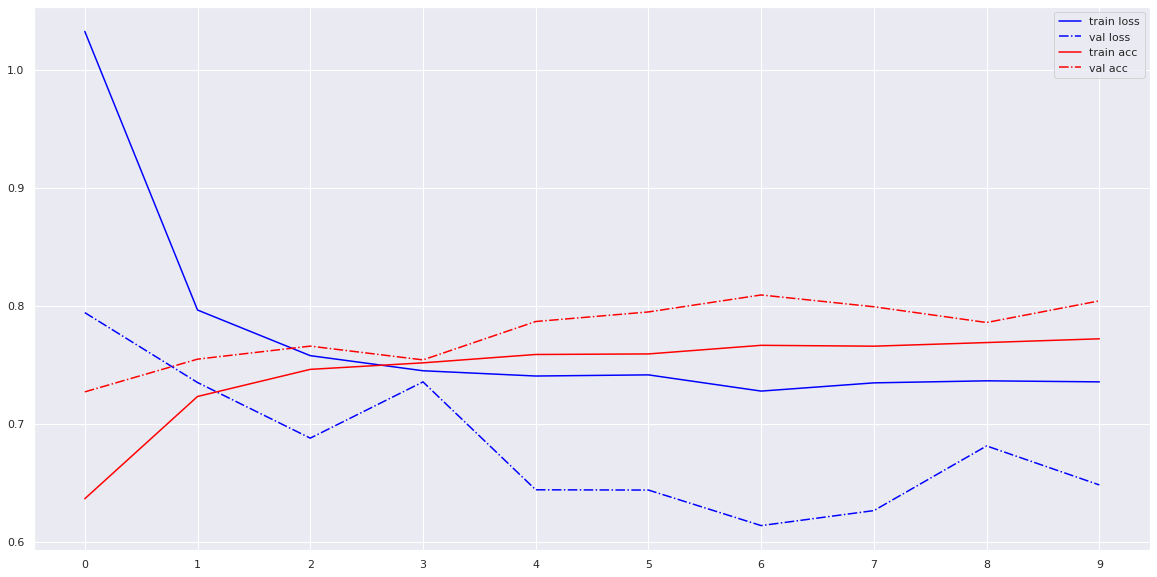

Best validation accuracy: 0.809166669845581, epoch = 6
Best validation loss: 0.6138102412223816, epoch = 6
2021-05-01 20:20:26,788 - root - INFO - OK.
2021-05-01 20:20:26,788 - root - INFO - OK.
2021-05-01 20:20:26,790 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:20:26,790 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:20:27,003 - root - INFO - OK.
2021-05-01 20:20:27,003 - root - INFO - OK.
2021-05-01 20:20:27,005 - root - INFO - Phase 2 starting...
2021-05-01 20:20:27,005 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 10s 13ms/step - loss: 0.6137 - accuracy: 0.8015 - val_loss: 0.5741 - val_accuracy: 0.8356
Epoch 2/25
600/600 [==============================] - 9s 13ms/step - loss: 0.4664 - accuracy: 0.8528 - val_loss: 0.5139 - val_accuracy: 0.8469
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 9s 13ms/step - loss: 0.3617 - accuracy: 0.

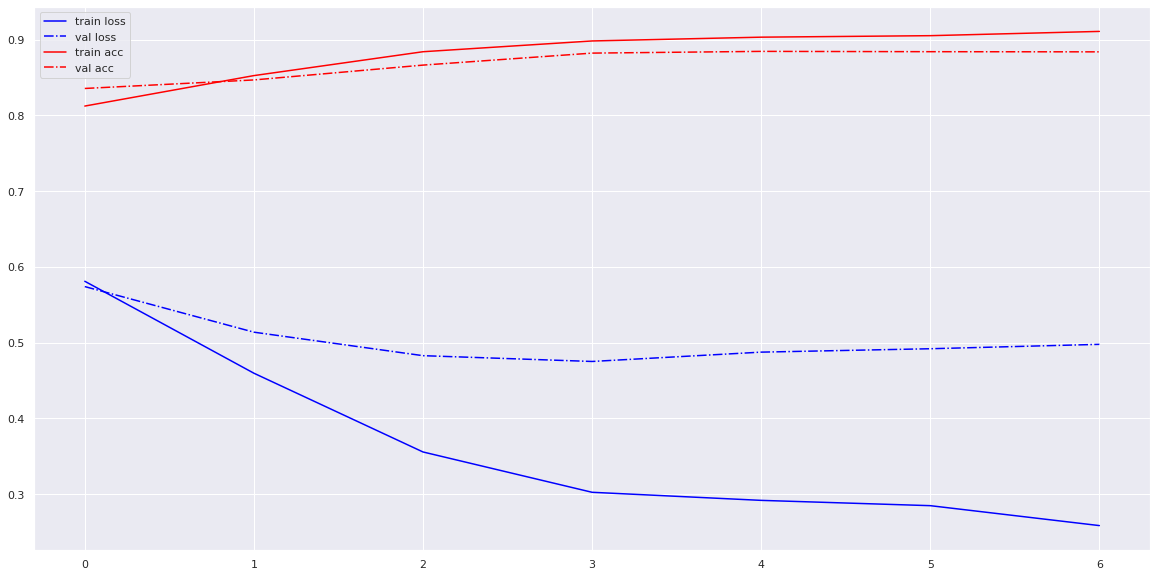

Best validation accuracy: 0.8845833539962769, epoch = 4
Best validation loss: 0.47526177763938904, epoch = 3


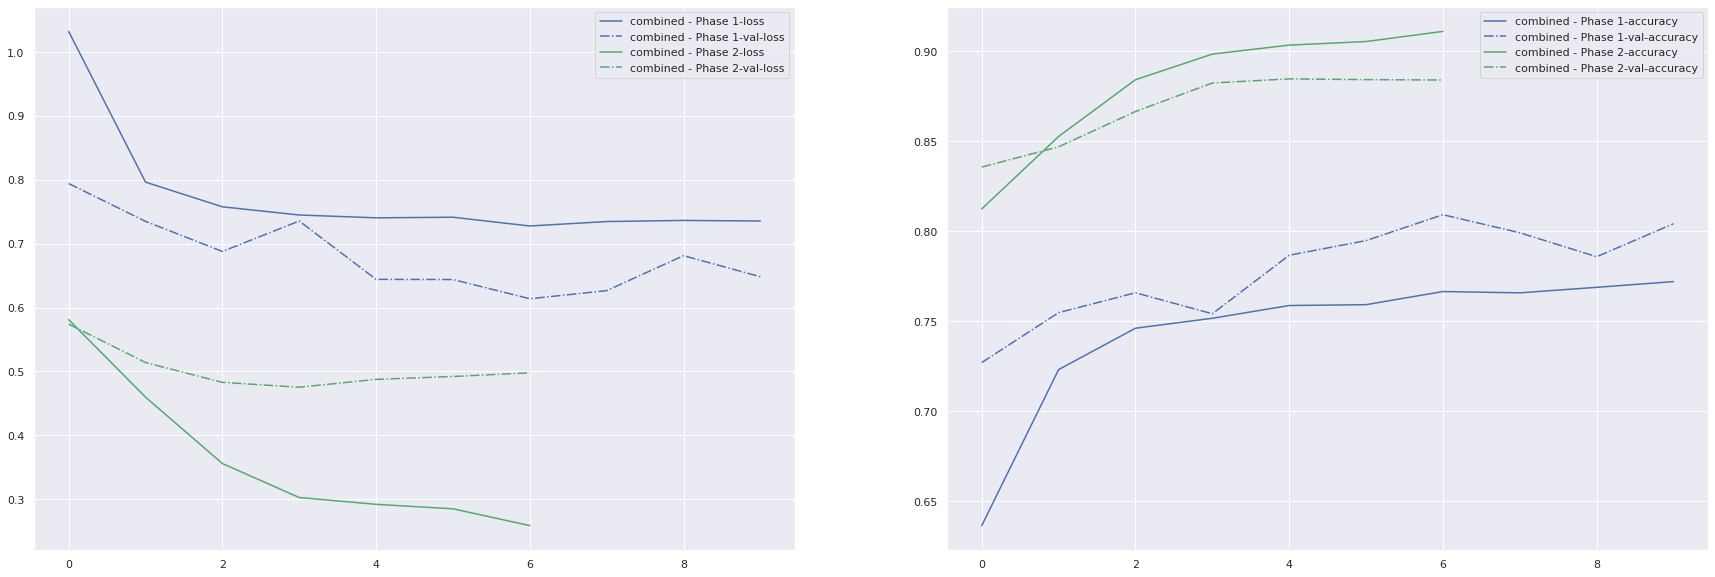


VGG16 : 15 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005, 0.9195833206176758]
VGG19 : 15 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651, 0.8845833539962769]
ResNet50 : 14 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958]
DenseNet : 14 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875, 0.9012500047683716]
Classifier names : 14 ['DecisionTre

In [ ]:
gc.collect()
gc.collect()
vgg19_ft = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_ft.trainable = False
print(vgg19_ft.summary())

myModel = ThreeAdditionalLayers.build(vgg19_ft.output_shape, n_classes)

vgg19_combined_model, vgg19_combined_history = combine_and_train_finetune(vgg19_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_pool')
vgg19_acc.append(max(vgg19_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## DenseNet

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 70, 70, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

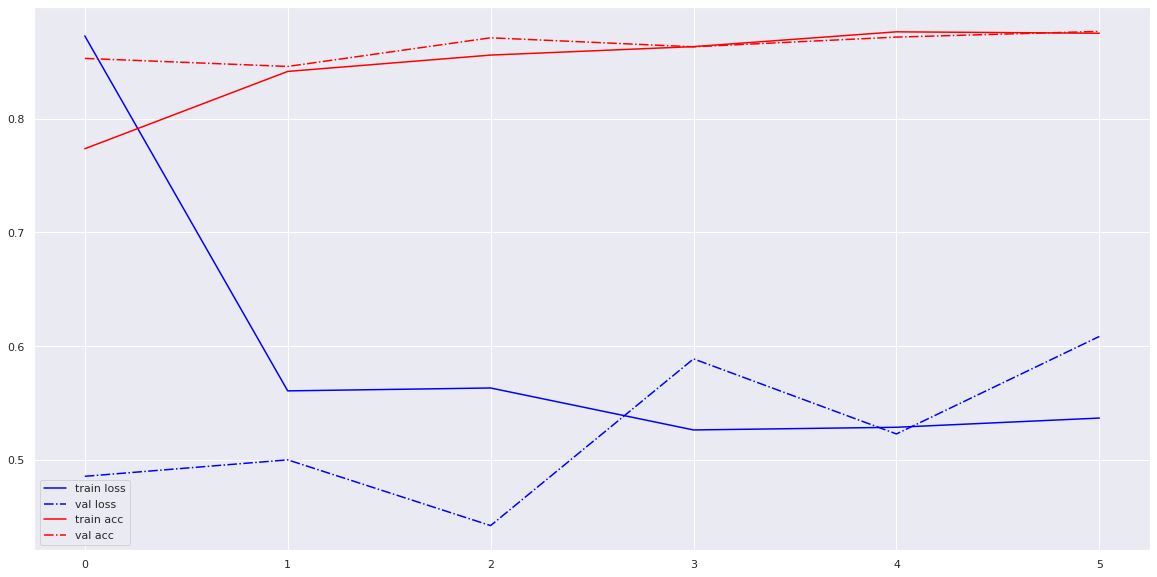

Best validation accuracy: 0.8768749833106995, epoch = 5
Best validation loss: 0.442064106464386, epoch = 2
2021-05-01 20:23:56,172 - root - INFO - OK.
2021-05-01 20:23:56,172 - root - INFO - OK.
2021-05-01 20:23:56,175 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:23:56,175 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:24:02,769 - root - INFO - OK.
2021-05-01 20:24:02,769 - root - INFO - OK.
2021-05-01 20:24:02,772 - root - INFO - Phase 2 starting...
2021-05-01 20:24:02,772 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 33s 35ms/step - loss: 13.1573 - accuracy: 0.8284 - val_loss: 5.5417 - val_accuracy: 0.8856
Epoch 2/26
600/600 [==============================] - 20s 31ms/step - loss: 4.5889 - accuracy: 0.8906 - val_loss: 3.8588 - val_accuracy: 0.8869
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 19s 30ms/step - loss: 3.2122 - accuracy:

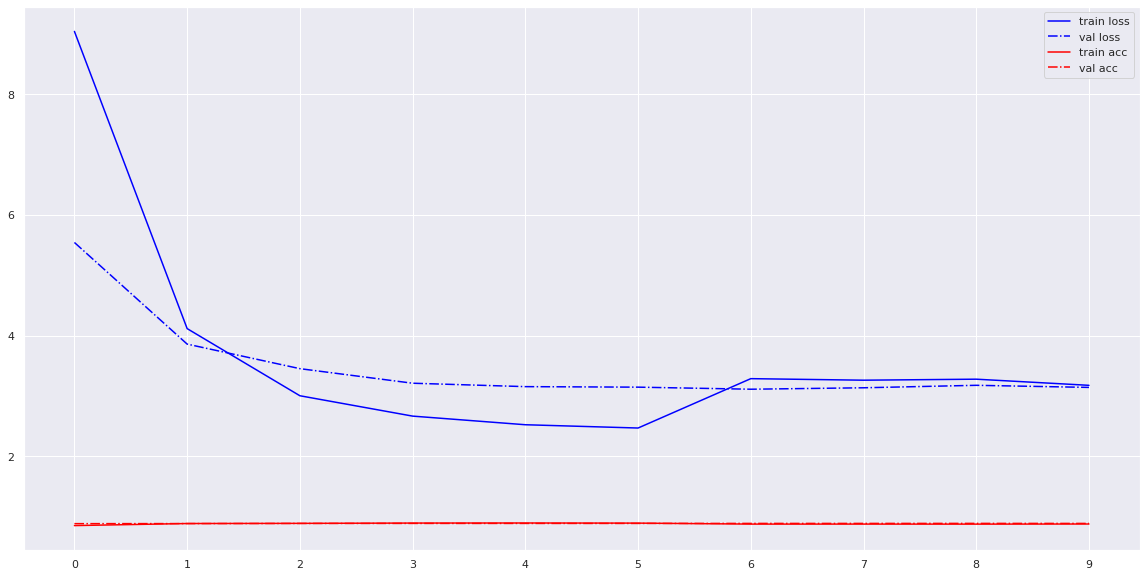

Best validation accuracy: 0.8899999856948853, epoch = 8
Best validation loss: 3.1117074489593506, epoch = 6


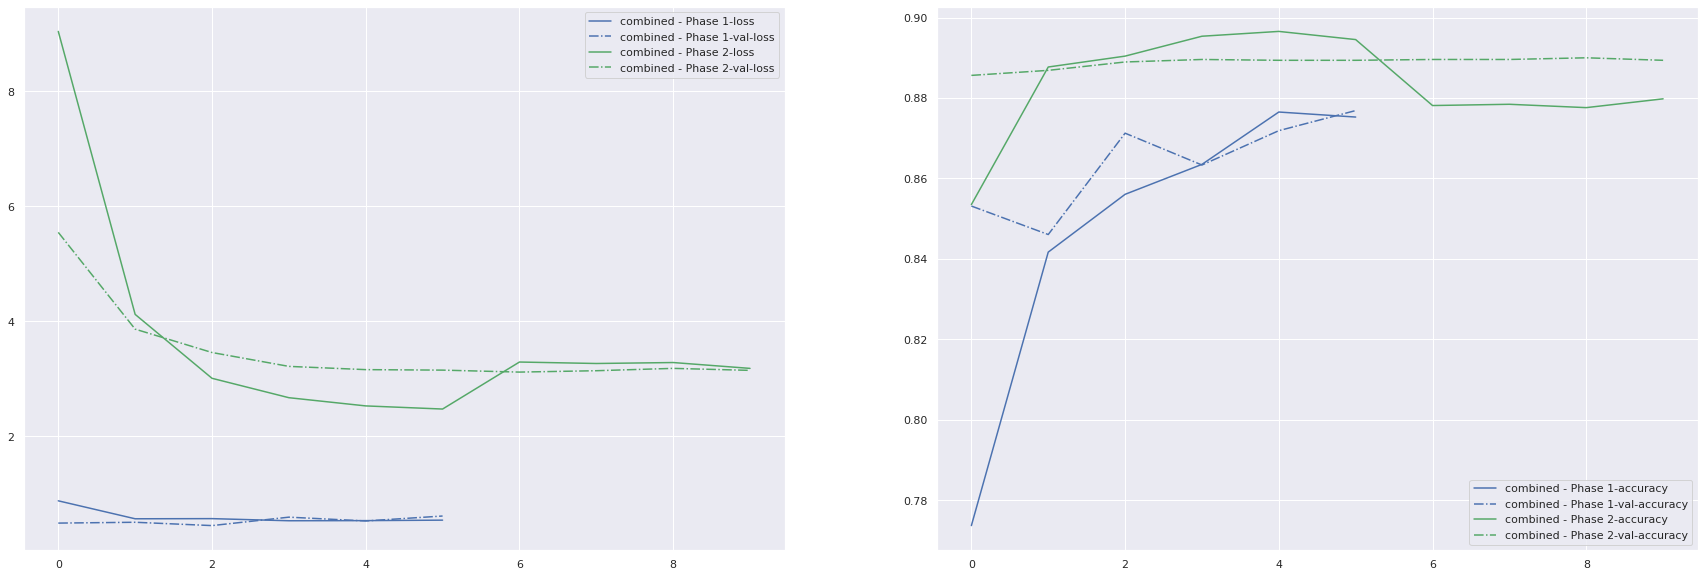


VGG16 : 15 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005, 0.9195833206176758]
VGG19 : 15 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651, 0.8845833539962769]
ResNet50 : 14 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958]
DenseNet : 15 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875, 0.9012500047683716, 0.8899999856948853]
Classifier name

In [ ]:
gc.collect()
gc.collect()
densenet_ft = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)

densenet_ft.trainable = False
print(densenet_ft.summary())

myModel = ThreeAdditionalLayers.build(densenet_ft.output_shape, n_classes)

densenet_combined_model, densenet_combined_history = combine_and_train_finetune(densenet_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block31_2_conv')
densenet_acc.append(max(densenet_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## Resnet50

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

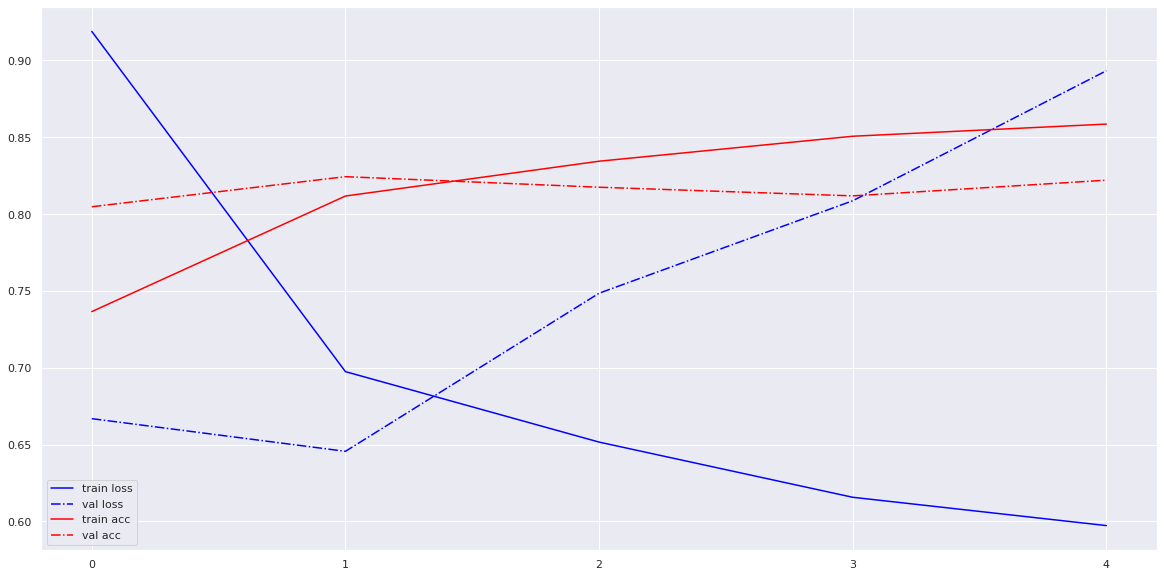

Best validation accuracy: 0.8243749737739563, epoch = 1
Best validation loss: 0.645636796951294, epoch = 1
2021-05-01 20:28:27,558 - root - INFO - OK.
2021-05-01 20:28:27,558 - root - INFO - OK.
2021-05-01 20:28:27,561 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:28:27,561 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:28:28,397 - root - INFO - OK.
2021-05-01 20:28:28,397 - root - INFO - OK.
2021-05-01 20:28:28,400 - root - INFO - Phase 2 starting...
2021-05-01 20:28:28,400 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 14s 16ms/step - loss: 2.8589 - accuracy: 0.8088 - val_loss: 1.8319 - val_accuracy: 0.8152
Epoch 2/26
600/600 [==============================] - 10s 14ms/step - loss: 0.7883 - accuracy: 0.8458 - val_loss: 1.0422 - val_accuracy: 0.8254
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 10s 15ms/step - loss: 0.6597 - accuracy: 

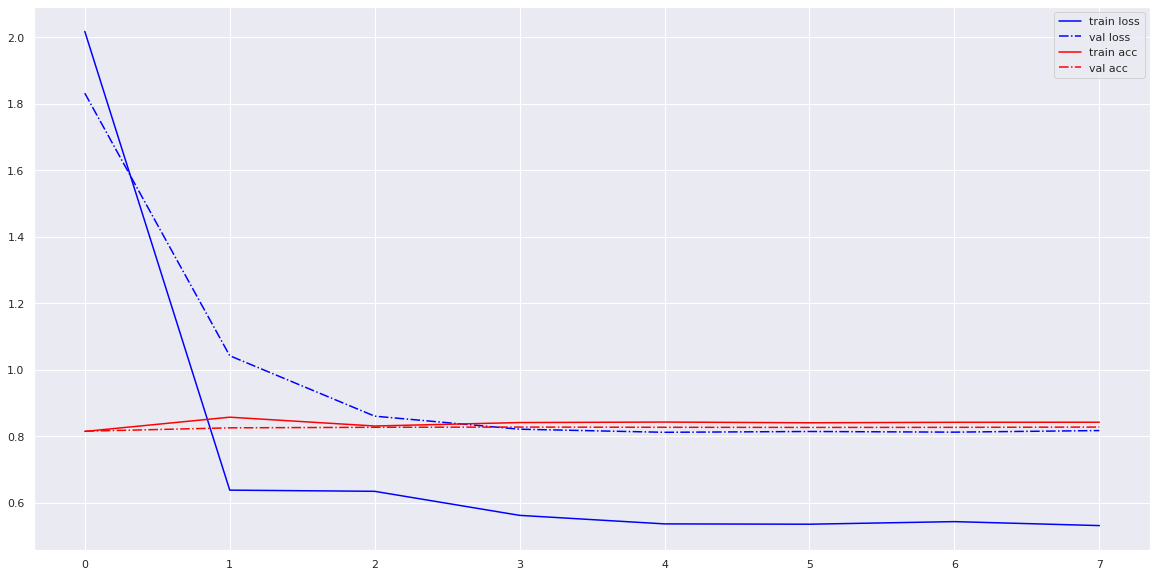

Best validation accuracy: 0.8277083039283752, epoch = 3
Best validation loss: 0.8119975328445435, epoch = 4


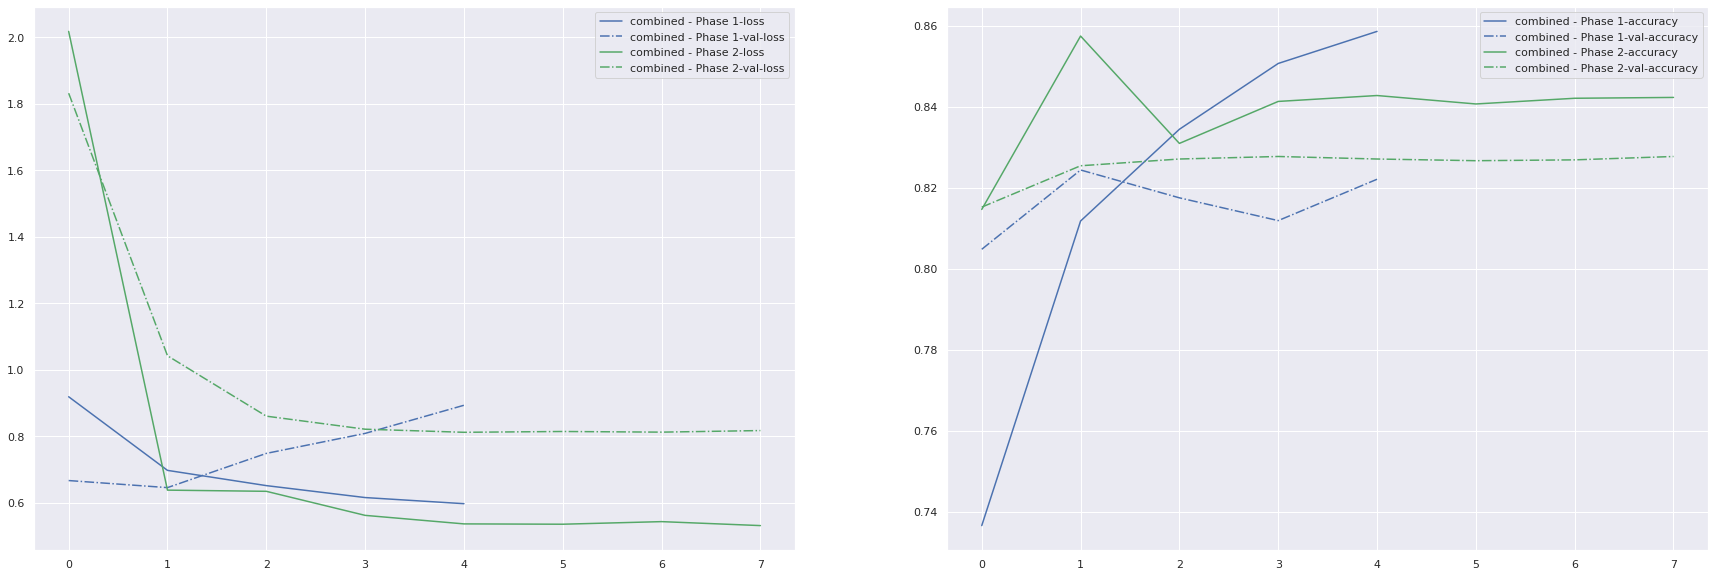


VGG16 : 15 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005, 0.9195833206176758]
VGG19 : 15 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651, 0.8845833539962769]
ResNet50 : 15 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958, 0.8277083039283752]
DenseNet : 15 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81875, 0.9012500047683716, 0.8899999856948

In [ ]:
gc.collect()
gc.collect()

resnet50_ft = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)

resnet50_ft.trainable = False
print(resnet50_ft.summary())

myModel = ThreeAdditionalLayers.build(resnet50_ft.output_shape, n_classes)

resnet50_combined_model, resnet50_combined_history = combine_and_train_finetune(resnet50_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block3_1_conv')
resnet50_acc.append(max(resnet50_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## Compare all runs

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.554792              0.700208   
3         DenseNet                0.692083              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.818125  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.776667  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.757292  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.838333  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  \
0             0.850000  0.732083  0.755208        0.855833   
1             0.815208  0.688750  0.720000        0.816458   
2             0.814583  0.704167  0.666875        0.819792   
3             0

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


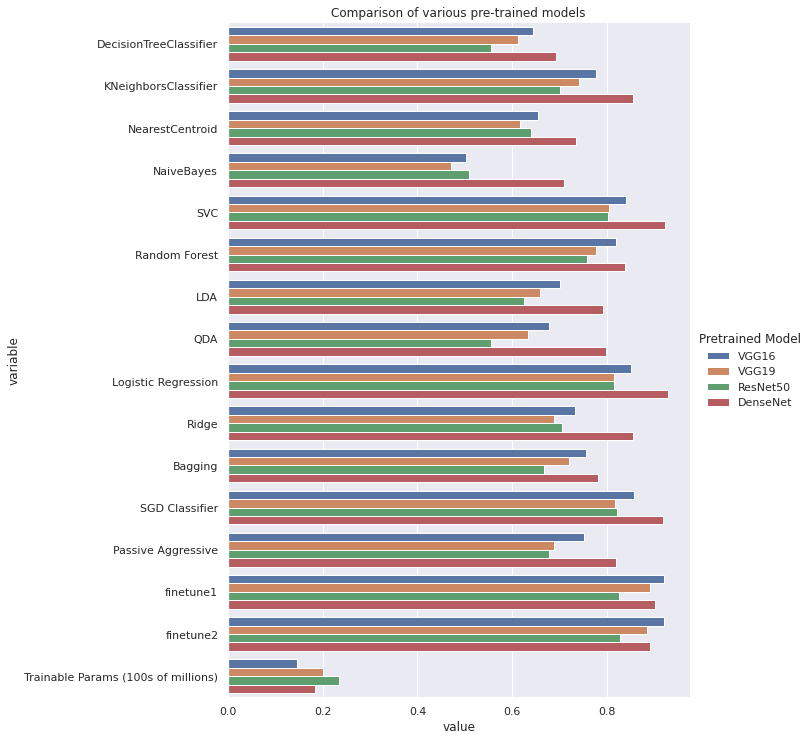

In [ ]:
densenet_names.append('finetune2')
compare_pretrained_models()

# Test all models with a very simple model

This model has just one layer.

Test all pre-trained models with this model

In [ ]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class BaseModelFinetune:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        print_model(model)
        return model

## VGG16

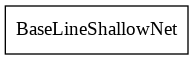

2021-05-01 20:32:14,703 - root - INFO - Phase 1 starting...
2021-05-01 20:32:14,703 - root - INFO - Phase 1 starting...
Epoch 1/25
600/600 [==============================] - 6s 8ms/step - loss: 0.9673 - accuracy: 0.6866 - val_loss: 0.5921 - val_accuracy: 0.8048
Epoch 2/25
600/600 [==============================] - 5s 7ms/step - loss: 0.5261 - accuracy: 0.8213 - val_loss: 0.4978 - val_accuracy: 0.8394
Epoch 3/25
600/600 [==============================] - 5s 7ms/step - loss: 0.4454 - accuracy: 0.8484 - val_loss: 0.4837 - val_accuracy: 0.8371
Epoch 4/25
600/600 [==============================] - 5s 7ms/step - loss: 0.4139 - accuracy: 0.8594 - val_loss: 0.4455 - val_accuracy: 0.8496
Epoch 5/25
600/600 [==============================] - 5s 7ms/step - loss: 0.3882 - accuracy: 0.8677 - val_loss: 0.4415 - val_accuracy: 0.8577
Epoch 6/25
600/600 [==============================] - 5s 7ms/step - loss: 0.3656 - accuracy: 0.8767 - val_loss: 0.4213 - val_accuracy: 0.8633
Epoch 7/25
600/600 [========

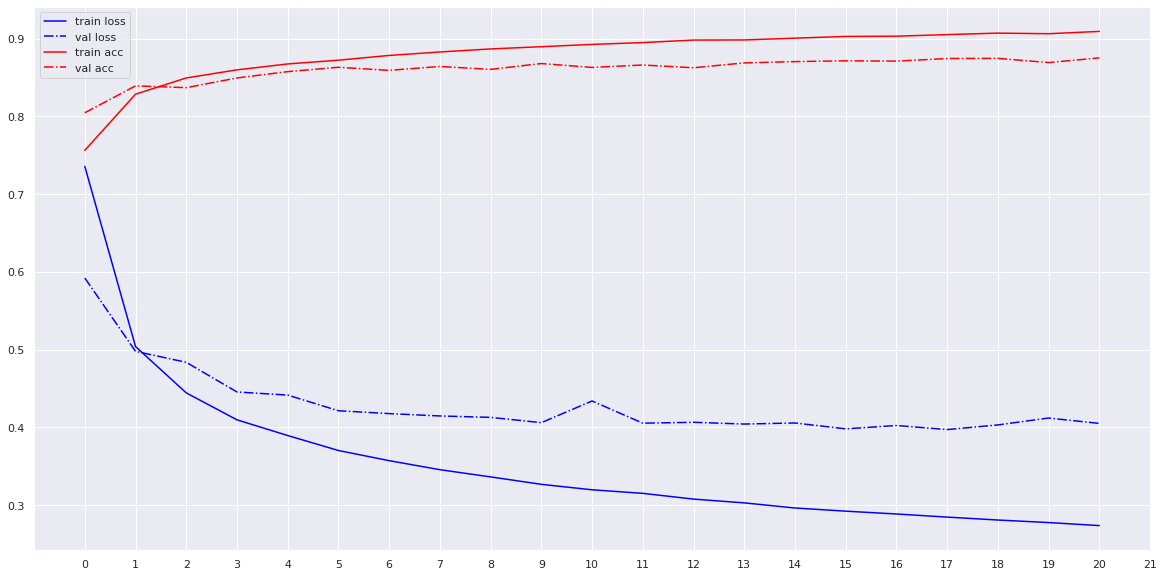

Best validation accuracy: 0.8754166960716248, epoch = 20
Best validation loss: 0.39714011549949646, epoch = 17
2021-05-01 20:34:11,895 - root - INFO - OK.
2021-05-01 20:34:11,895 - root - INFO - OK.
2021-05-01 20:34:11,897 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:34:11,897 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:34:12,022 - root - INFO - OK.
2021-05-01 20:34:12,022 - root - INFO - OK.
2021-05-01 20:34:12,025 - root - INFO - Phase 2 starting...
2021-05-01 20:34:12,025 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 9s 13ms/step - loss: 0.3372 - accuracy: 0.8909 - val_loss: 0.4183 - val_accuracy: 0.8692
Epoch 2/25
600/600 [==============================] - 8s 12ms/step - loss: 0.1944 - accuracy: 0.9308 - val_loss: 0.3262 - val_accuracy: 0.9019
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 8s 12ms/step - loss: 0.0986 - accuracy:

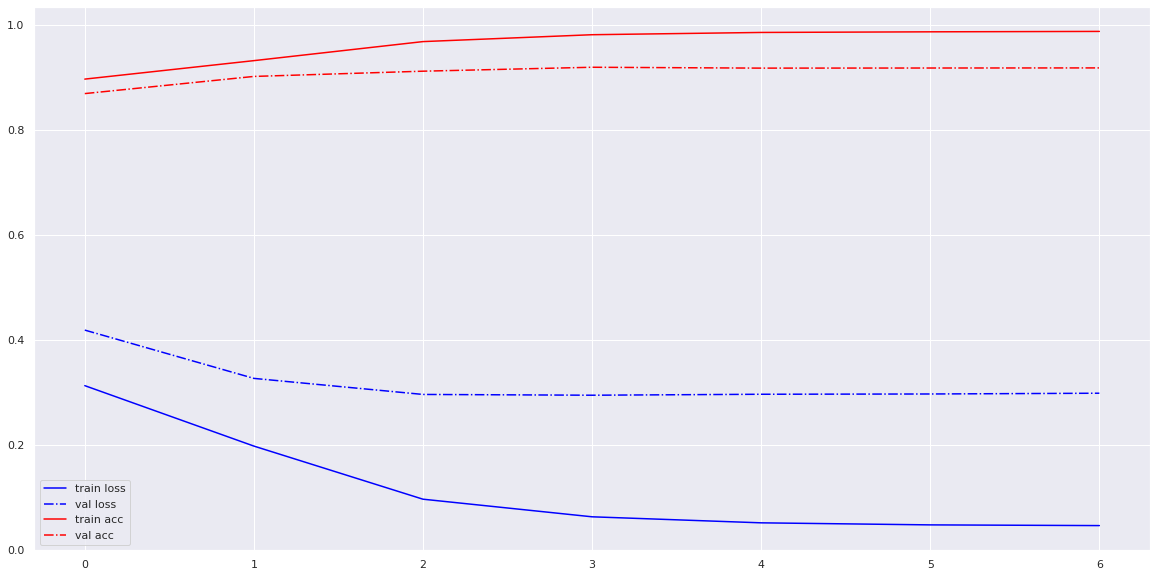

Best validation accuracy: 0.9193750023841858, epoch = 3
Best validation loss: 0.2941436767578125, epoch = 3


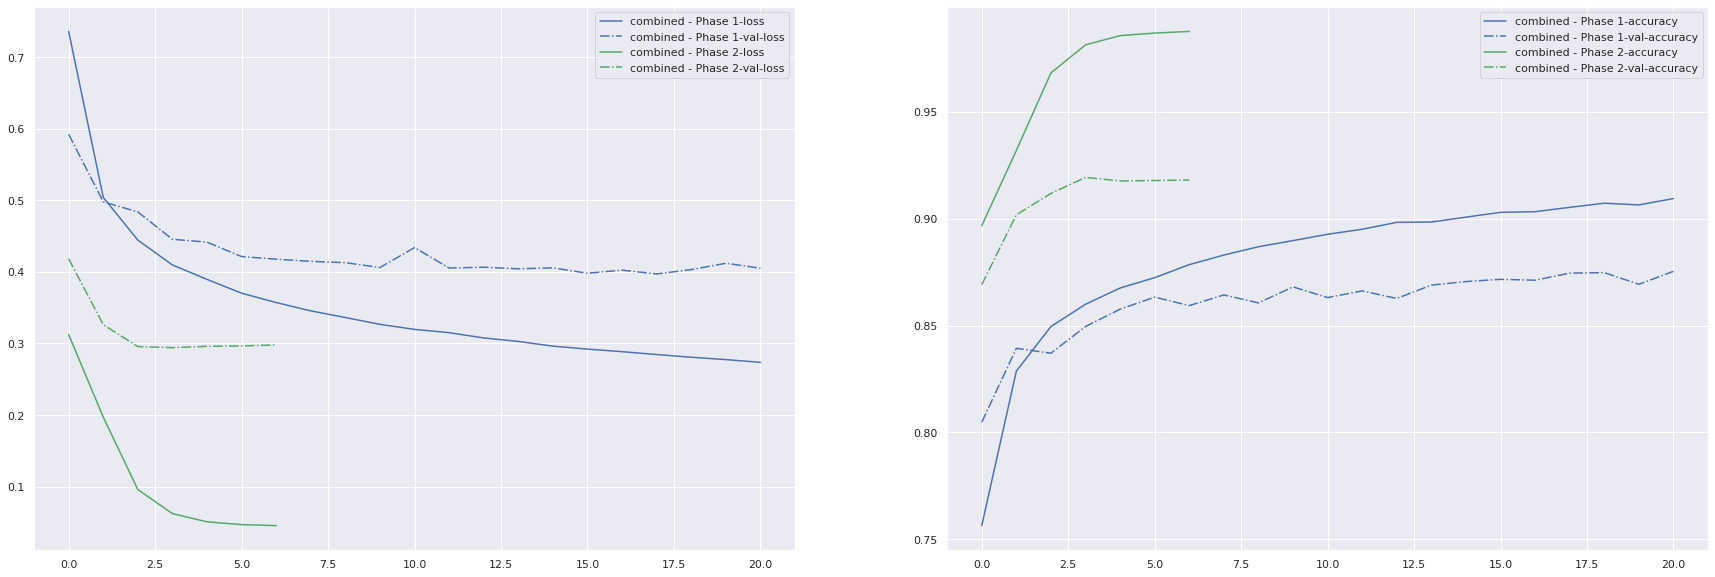

In [ ]:
vgg16_ft = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16_ft.trainable = False

myModel = BaseModelFinetune.build(vgg16_ft.output_shape, n_classes)

vgg16_combined_model, vgg16_combined_history = combine_and_train_finetune(vgg16_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')
vgg16_acc.append(max(vgg16_combined_history.history['val_accuracy']))


## VGG19

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

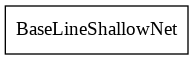

2021-05-01 20:35:27,491 - root - INFO - Phase 1 starting...
2021-05-01 20:35:27,491 - root - INFO - Phase 1 starting...
Epoch 1/25
600/600 [==============================] - 7s 9ms/step - loss: 1.0766 - accuracy: 0.6311 - val_loss: 0.7168 - val_accuracy: 0.7467
Epoch 2/25
600/600 [==============================] - 6s 8ms/step - loss: 0.6434 - accuracy: 0.7739 - val_loss: 0.6180 - val_accuracy: 0.7881
Epoch 3/25
600/600 [==============================] - 6s 8ms/step - loss: 0.5711 - accuracy: 0.8013 - val_loss: 0.5927 - val_accuracy: 0.7987
Epoch 4/25
600/600 [==============================] - 6s 8ms/step - loss: 0.5362 - accuracy: 0.8126 - val_loss: 0.5522 - val_accuracy: 0.8090
Epoch 5/25
600/600 [==============================] - 6s 8ms/step - loss: 0.4991 - accuracy: 0.8257 - val_loss: 0.5507 - val_accuracy: 0.8077
Epoch 6/25
600/600 [==============================] - 6s 8ms/step - loss: 0.4827 - accuracy: 0.8289 - val_loss: 0.5224 - val_accuracy: 0.8215
Epoch 7/25
600/600 [========

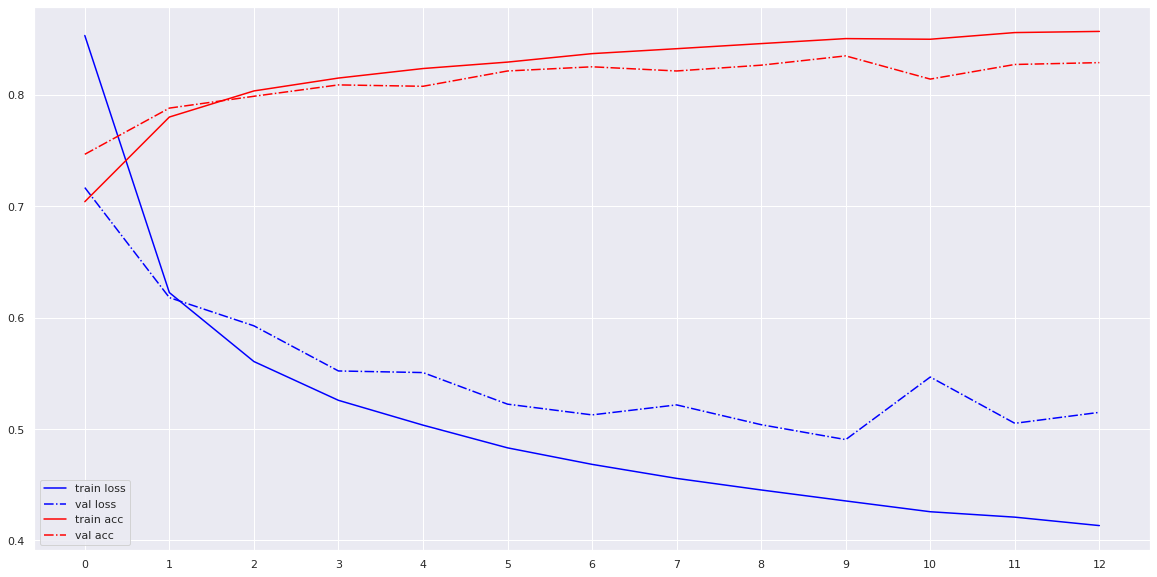

Best validation accuracy: 0.8349999785423279, epoch = 9
Best validation loss: 0.4905407130718231, epoch = 9
2021-05-01 20:36:50,573 - root - INFO - OK.
2021-05-01 20:36:50,573 - root - INFO - OK.
2021-05-01 20:36:50,579 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:36:50,579 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:36:50,745 - root - INFO - OK.
2021-05-01 20:36:50,745 - root - INFO - OK.
2021-05-01 20:36:50,748 - root - INFO - Phase 2 starting...
2021-05-01 20:36:50,748 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 9s 12ms/step - loss: 0.4324 - accuracy: 0.8516 - val_loss: 0.4638 - val_accuracy: 0.8415
Epoch 2/25
600/600 [==============================] - 8s 12ms/step - loss: 0.2955 - accuracy: 0.8954 - val_loss: 0.4113 - val_accuracy: 0.8642
Epoch 3/25
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 8s 12ms/step - loss: 0.1962 - accuracy: 0.

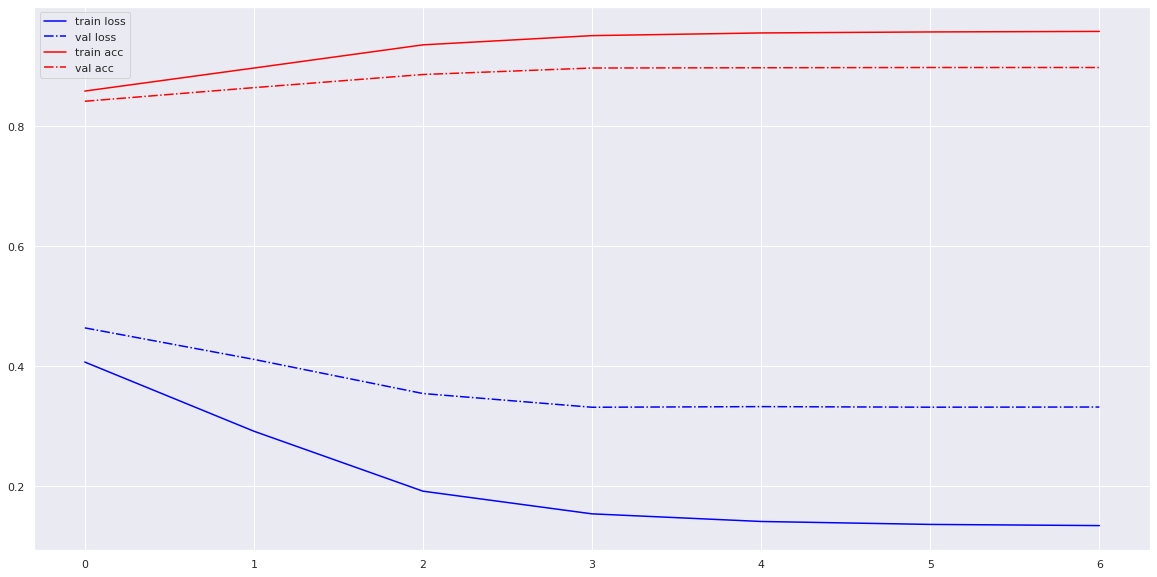

Best validation accuracy: 0.8977083563804626, epoch = 5
Best validation loss: 0.33152422308921814, epoch = 3


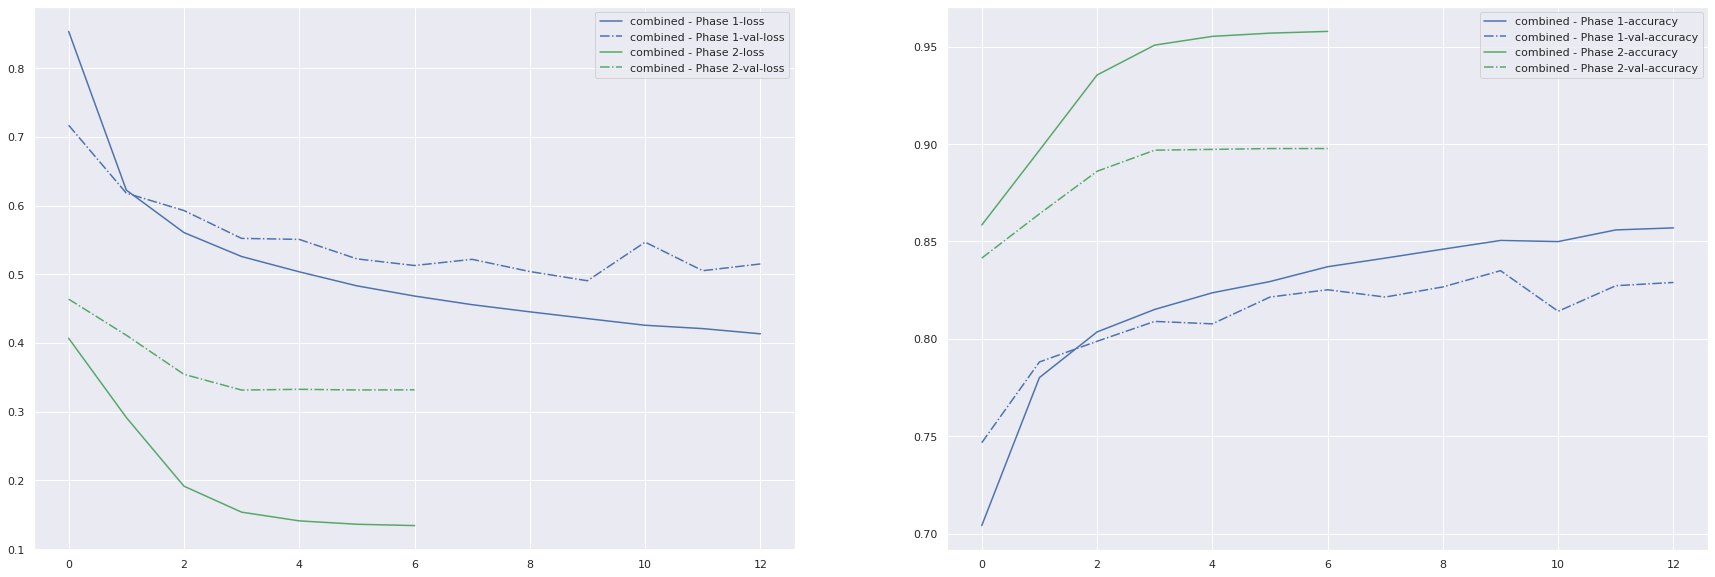


VGG16 : 16 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005, 0.9195833206176758, 0.9193750023841858]
VGG19 : 16 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651, 0.8845833539962769, 0.8977083563804626]
ResNet50 : 15 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958, 0.8277083039283752]
DenseNet : 15 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81

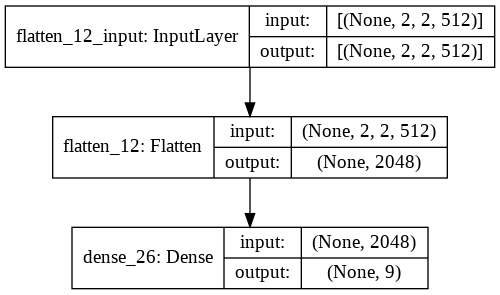

In [ ]:
gc.collect()
gc.collect()
vgg19_ft = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_ft.trainable = False
print(vgg19_ft.summary())

myModel = BaseModelFinetune.build(vgg19_ft.output_shape, n_classes)

vgg19_combined_model, vgg19_combined_history = combine_and_train_finetune(vgg19_ft, myModel, trainX, trainY, valX, valY, 25, 'block4_pool')
vgg19_acc.append(max(vgg19_combined_history.history['val_accuracy']))
print_all_saved_accuracies()
print_model(myModel)

## DenseNet

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 3)    0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

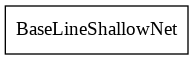

2021-05-01 20:38:00,681 - root - INFO - Phase 1 starting...
2021-05-01 20:38:00,681 - root - INFO - Phase 1 starting...
Epoch 1/26
600/600 [==============================] - 30s 32ms/step - loss: 0.7589 - accuracy: 0.7836 - val_loss: 0.4442 - val_accuracy: 0.8721
Epoch 2/26
600/600 [==============================] - 18s 27ms/step - loss: 0.3741 - accuracy: 0.8921 - val_loss: 0.4550 - val_accuracy: 0.8806
Epoch 3/26
600/600 [==============================] - 18s 27ms/step - loss: 0.3015 - accuracy: 0.9126 - val_loss: 0.4702 - val_accuracy: 0.8746
Epoch 4/26
600/600 [==============================] - 17s 27ms/step - loss: 0.2548 - accuracy: 0.9218 - val_loss: 0.4801 - val_accuracy: 0.8838
Epoch 00004: early stopping


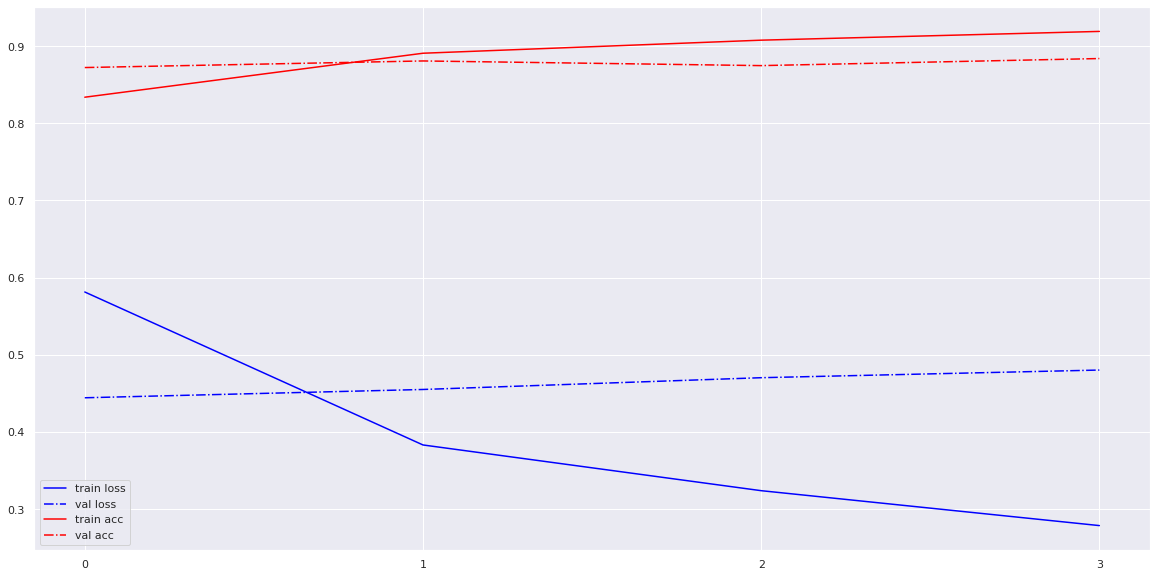

Best validation accuracy: 0.8837500214576721, epoch = 3
Best validation loss: 0.44419991970062256, epoch = 0
2021-05-01 20:39:27,100 - root - INFO - OK.
2021-05-01 20:39:27,100 - root - INFO - OK.
2021-05-01 20:39:27,102 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:39:27,102 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:39:33,349 - root - INFO - OK.
2021-05-01 20:39:33,349 - root - INFO - OK.
2021-05-01 20:39:33,351 - root - INFO - Phase 2 starting...
2021-05-01 20:39:33,351 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 31s 33ms/step - loss: 0.9639 - accuracy: 0.8186 - val_loss: 0.6271 - val_accuracy: 0.8717
Epoch 2/26
600/600 [==============================] - 18s 29ms/step - loss: 0.3694 - accuracy: 0.9033 - val_loss: 0.5274 - val_accuracy: 0.8910
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 19s 29ms/step - loss: 0.3385 - accuracy

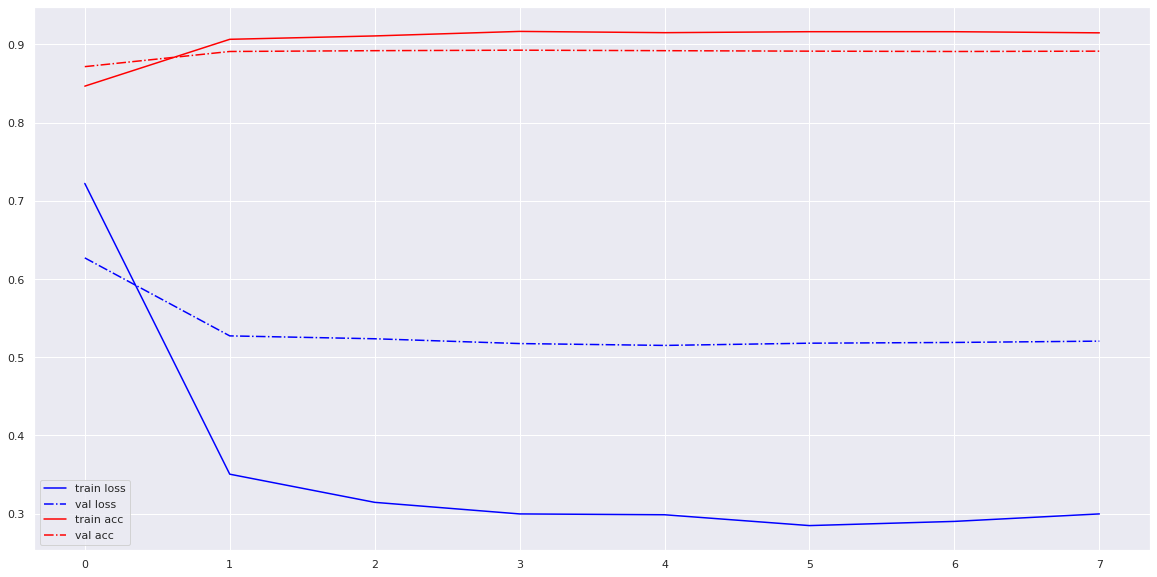

Best validation accuracy: 0.8927083611488342, epoch = 3
Best validation loss: 0.5151799917221069, epoch = 4


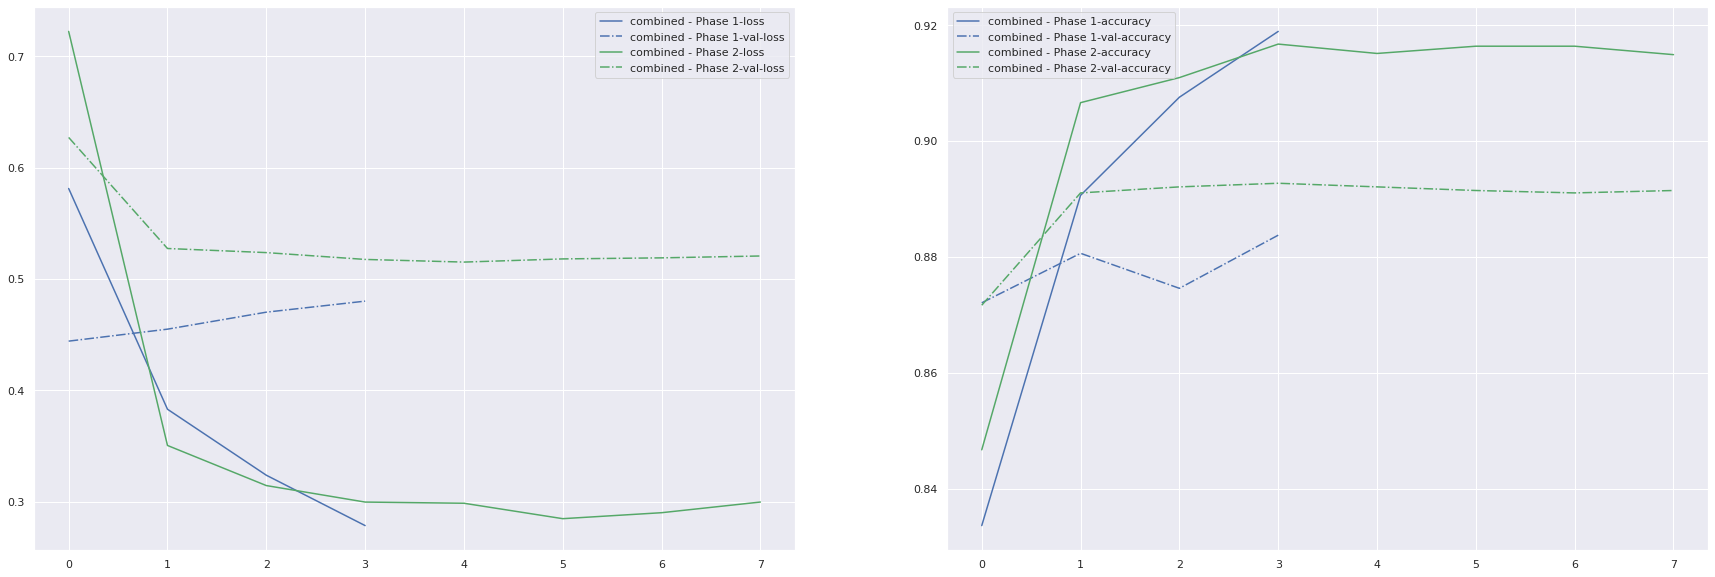


VGG16 : 16 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005, 0.9195833206176758, 0.9193750023841858]
VGG19 : 16 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651, 0.8845833539962769, 0.8977083563804626]
ResNet50 : 15 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958, 0.8277083039283752]
DenseNet : 16 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 0.78, 0.916875, 0.81

In [ ]:
gc.collect()
gc.collect()
densenet_ft = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)

densenet_ft.trainable = False
print(densenet_ft.summary())

myModel = BaseModelFinetune.build(densenet_ft.output_shape, n_classes)

densenet_combined_model, densenet_combined_history = combine_and_train_finetune(densenet_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block31_2_conv')
densenet_acc.append(max(densenet_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## ResNet50

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

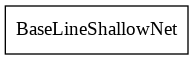

2021-05-01 20:42:24,048 - root - INFO - Phase 1 starting...
2021-05-01 20:42:24,048 - root - INFO - Phase 1 starting...
Epoch 1/26
600/600 [==============================] - 11s 12ms/step - loss: 0.8213 - accuracy: 0.7429 - val_loss: 0.5794 - val_accuracy: 0.8313
Epoch 2/26
600/600 [==============================] - 8s 11ms/step - loss: 0.3922 - accuracy: 0.8785 - val_loss: 0.6045 - val_accuracy: 0.8363
Epoch 3/26
600/600 [==============================] - 8s 11ms/step - loss: 0.2975 - accuracy: 0.9086 - val_loss: 0.6433 - val_accuracy: 0.8375
Epoch 4/26
600/600 [==============================] - 8s 11ms/step - loss: 0.2368 - accuracy: 0.9242 - val_loss: 0.6687 - val_accuracy: 0.8427
Epoch 00004: early stopping


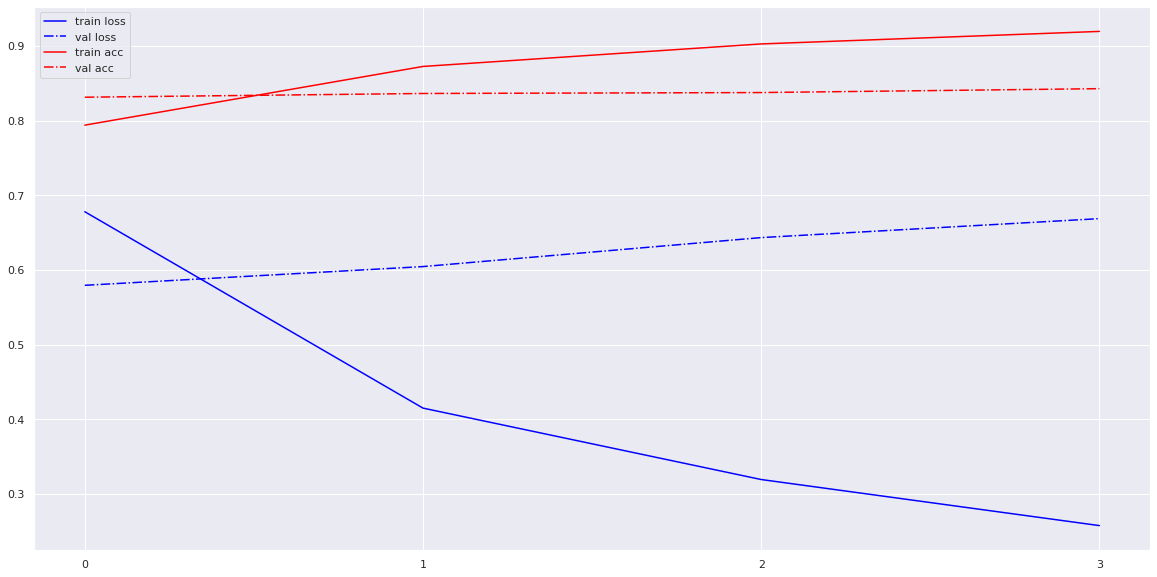

Best validation accuracy: 0.8427083492279053, epoch = 3
Best validation loss: 0.5793719291687012, epoch = 0
2021-05-01 20:43:01,476 - root - INFO - OK.
2021-05-01 20:43:01,476 - root - INFO - OK.
2021-05-01 20:43:01,479 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:43:01,479 - root - INFO - Loading weights from checkpoint...
2021-05-01 20:43:02,161 - root - INFO - OK.
2021-05-01 20:43:02,161 - root - INFO - OK.
2021-05-01 20:43:02,163 - root - INFO - Phase 2 starting...
2021-05-01 20:43:02,163 - root - INFO - Phase 2 starting...
Epoch 1/26
600/600 [==============================] - 13s 15ms/step - loss: 1.4014 - accuracy: 0.7985 - val_loss: 1.3436 - val_accuracy: 0.8067
Epoch 2/26
600/600 [==============================] - 9s 13ms/step - loss: 0.5079 - accuracy: 0.8662 - val_loss: 0.9612 - val_accuracy: 0.8152
Epoch 3/26
Learning Rate: 9.999999747378752e-06 --> 3.6787946555705275e-06
600/600 [==============================] - 9s 13ms/step - loss: 0.3399 - accuracy: 0

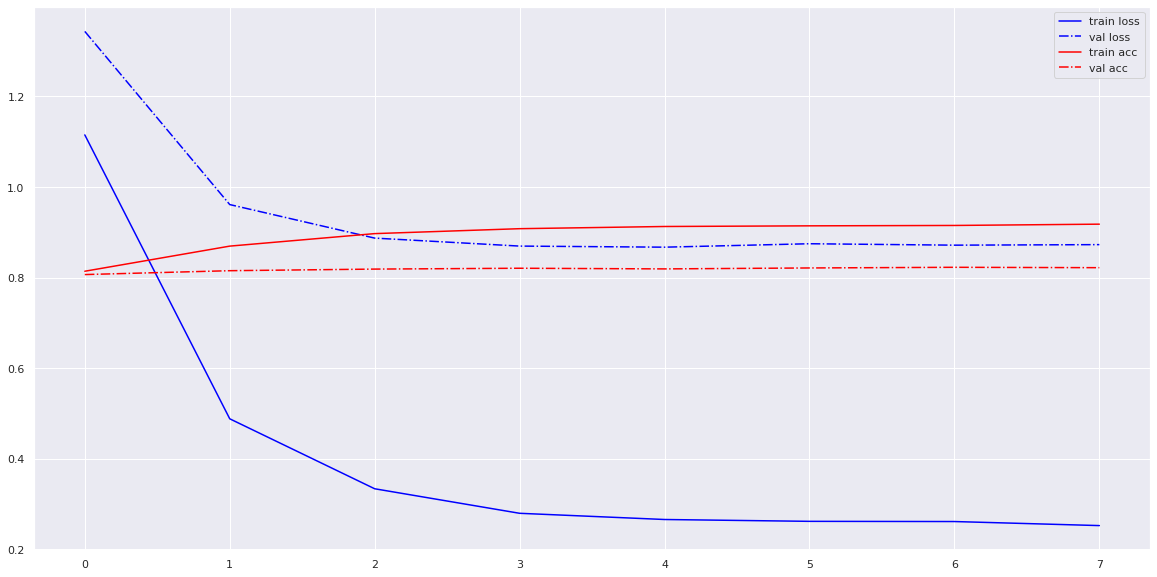

Best validation accuracy: 0.8227083086967468, epoch = 6
Best validation loss: 0.8671393990516663, epoch = 4


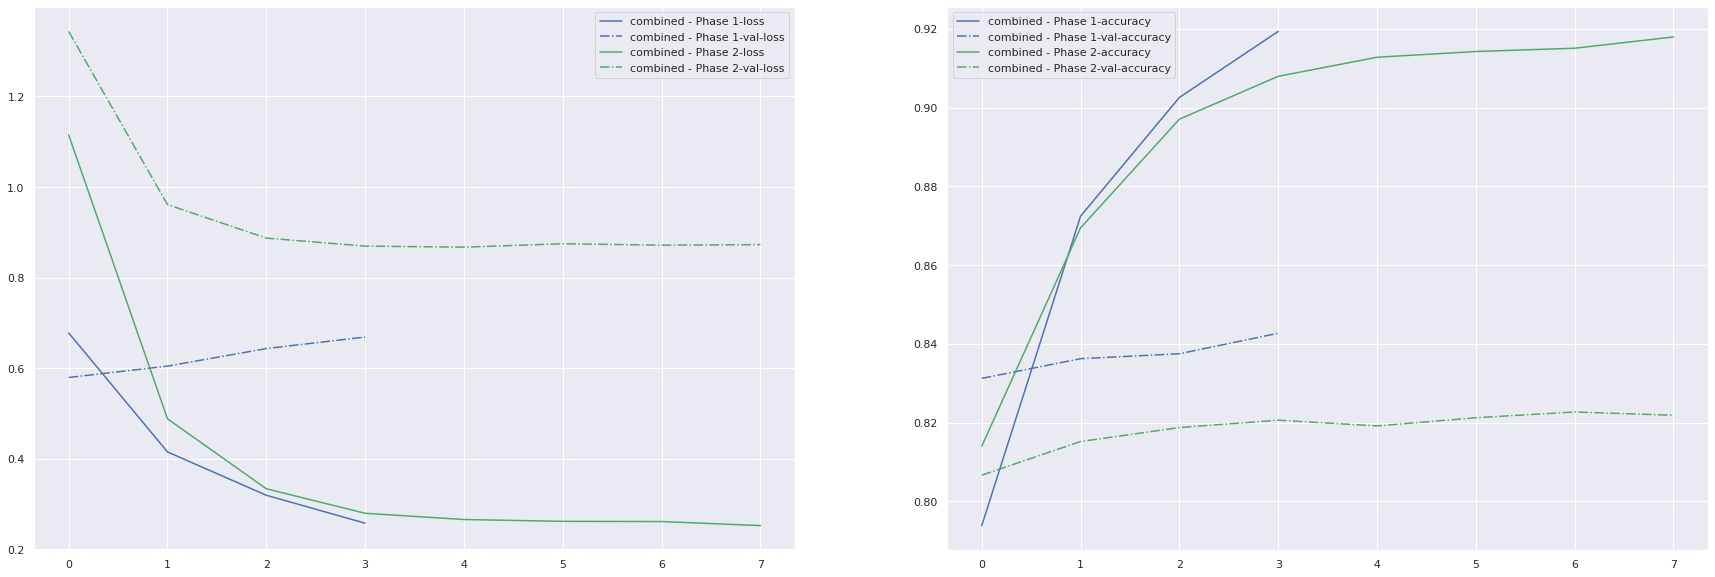


VGG16 : 16 [0.643125, 0.7775, 0.6533333333333333, 0.5022916666666667, 0.8402083333333333, 0.818125, 0.6997916666666667, 0.6775, 0.85, 0.7320833333333333, 0.7552083333333334, 0.8558333333333333, 0.750625, 0.9200000166893005, 0.9195833206176758, 0.9193750023841858]
VGG19 : 16 [0.6110416666666667, 0.7410416666666667, 0.6166666666666667, 0.47041666666666665, 0.80375, 0.7766666666666666, 0.659375, 0.633125, 0.8152083333333333, 0.68875, 0.72, 0.8164583333333333, 0.6885416666666667, 0.89041668176651, 0.8845833539962769, 0.8977083563804626]
ResNet50 : 16 [0.5547916666666667, 0.7002083333333333, 0.639375, 0.5095833333333334, 0.80125, 0.7572916666666667, 0.625, 0.5541666666666667, 0.8145833333333333, 0.7041666666666667, 0.666875, 0.8197916666666667, 0.6770833333333334, 0.8254166841506958, 0.8277083039283752, 0.8227083086967468]
DenseNet : 16 [0.6920833333333334, 0.8535416666666666, 0.734375, 0.71, 0.9216666666666666, 0.8383333333333334, 0.791875, 0.7979166666666667, 0.9275, 0.8545833333333334, 

In [ ]:
gc.collect()
gc.collect()

resnet50_ft = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)

resnet50_ft.trainable = False
print(resnet50_ft.summary())

myModel = BaseModelFinetune.build(resnet50_ft.output_shape, n_classes)

resnet50_combined_model, resnet50_combined_history = combine_and_train_finetune(resnet50_ft, myModel, trainX, trainY, valX, valY, 26, 'conv5_block3_1_conv')
resnet50_acc.append(max(resnet50_combined_history.history['val_accuracy']))
print_all_saved_accuracies()

## Compare

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.554792              0.700208   
3         DenseNet                0.692083              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.818125  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.776667  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.757292  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.838333  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  \
0             0.850000  0.732083  0.755208        0.855833   
1             0.815208  0.688750  0.720000        0.816458   
2             0.814583  0.704167  0.666875        0.819792   
3             0

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


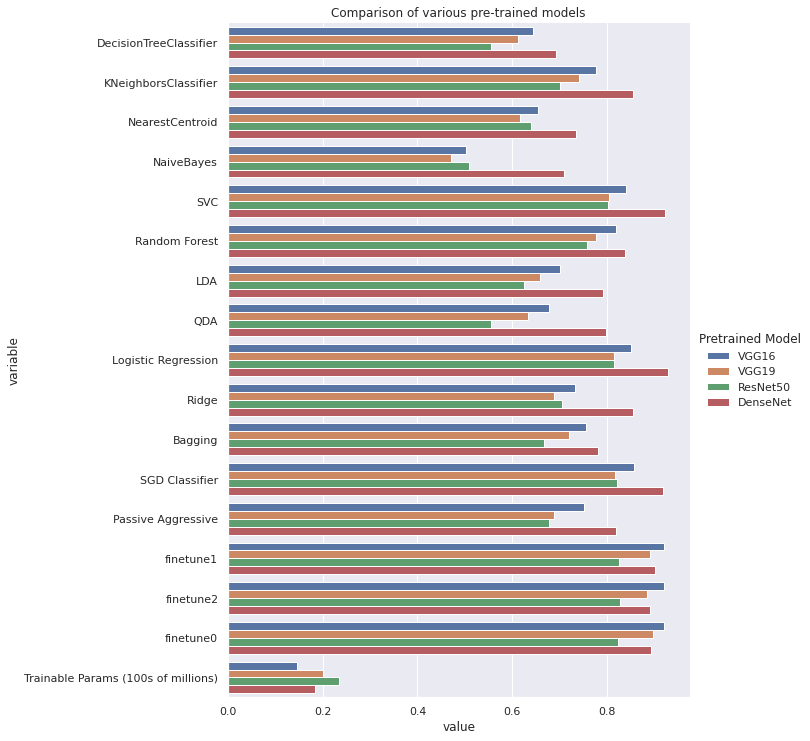

In [ ]:
densenet_names.append('finetune0')

compare_pretrained_models()
#densenet_names = densenet_names[:-2]

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611042              0.741042   
2         ResNet50                0.554792              0.700208   
3         DenseNet                0.692083              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.818125  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.776667  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.757292  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.838333  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  \
0             0.850000  0.732083  0.755208        0.855833   
1             0.815208  0.688750  0.720000        0.816458   
2             0.814583  0.704167  0.666875        0.819792   
3             0

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


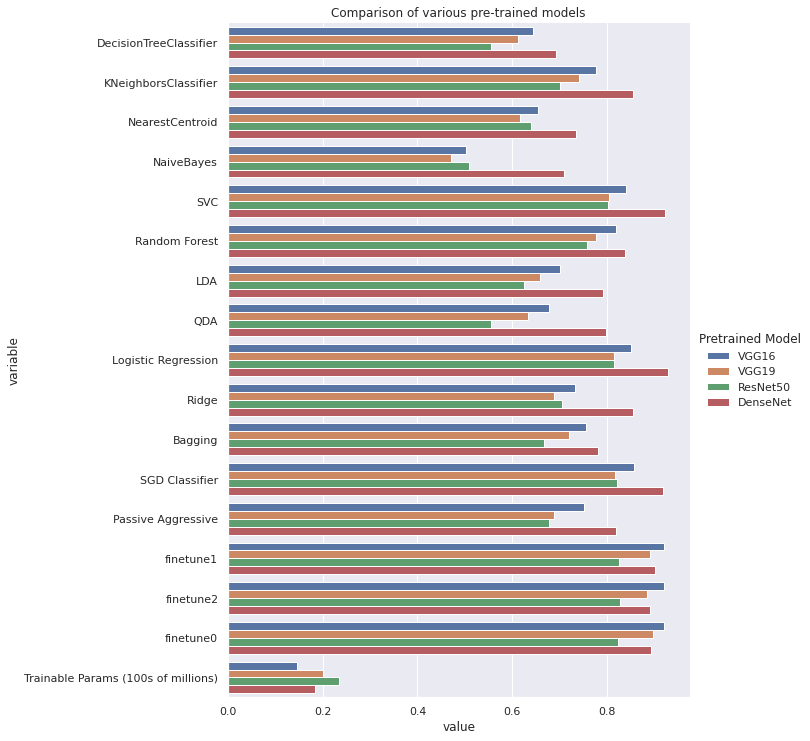

In [ ]:
compare_pretrained_models((30, 30,))